# Importaciones y procesamiento instancias

In [1]:
# IMPORTAR LIBRERÍAS
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import os
import itertools

In [2]:
# LECTURA DE ARCHIVOS

# FUNCIÓN PARA LEER ARCHIVOS
def read_graph_from_file(filename):
    graph = nx.read_gml(filename)
    new_labels = {node: int(node) for node in graph.nodes()}
    graph = nx.relabel_nodes(graph, new_labels)
    return graph

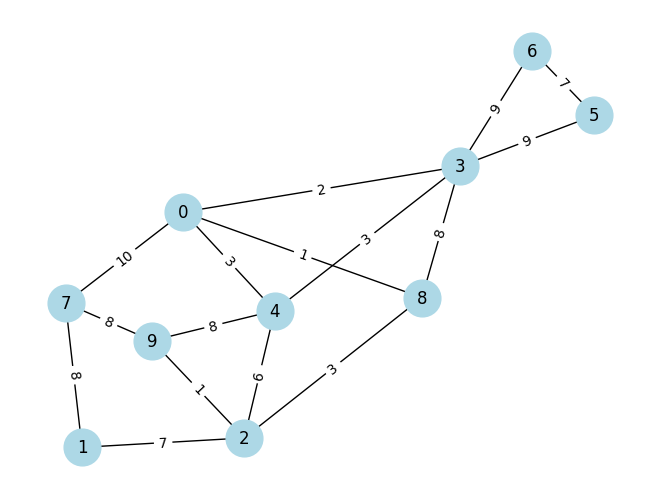

In [3]:
# LECTURA DEL GRAFO
# Para la ruta en caso de MacOs ocupar /, en cualquier otro caso ocupar \
graph_filename = 'Instancias_T3/Grafo.gml' 
G = read_graph_from_file(graph_filename)

# Dibujar el grafo
pos = nx.spring_layout(G, seed = 1)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=700)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.show()

#### definimos aqui la funcion de graficar la solucion

In [4]:
def graficar_solucion(G, caminos, s, alpha, beta):
    # Posicionamiento de nodos
    pos = nx.spring_layout(G, seed=1)
    
    plt.figure(figsize=(10, 7))

    # Dibujar grafo base (gris)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=700, alpha=0.5)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    # Graficar las rutas óptimas para cables con colores
    M = nx.MultiDiGraph()
    for destino, camino in caminos.items():
        for i in range(len(camino) - 1):
            u, v = camino[i], camino[i + 1]
            peso = G[u][v]['weight']
            M.add_edge(u, v, weight=peso)

    # Asignar colores a cada destino
    colores = plt.cm.rainbow(np.linspace(0, 1, len(caminos)))
    contador = 0

    for color, (destino, camino) in zip(colores, caminos.items()):
        arcos_camino = [(camino[i], camino[i + 1]) for i in range(len(camino) - 1)]

        # Dibujar etiquetas de peso en los arcos
        nx.draw_networkx_edge_labels(
            M, pos, edge_labels={(u, v): G[u][v]['weight'] for u, v in arcos_camino}
        )

        # Dibujar los arcos con colores que representan los cables
        for u, v in arcos_camino:
            nx.draw_networkx_edges(
                M, pos, edgelist=[(u, v)], edge_color=[color], width=2,
                connectionstyle=f'arc3,rad={-0.1 * contador}'
            )
        contador += 1

    plt.title(f"Rutas óptimas para alpha = {alpha} y beta = {beta}")
    plt.show()

# Parte I

- $\alpha$: costo del largo total del tubería por distancia $[\frac{costo}{metros}] \rightarrow$ lo multiplico por el largo del árbol de rutas mínimas $\rightarrow$ calculo el costo de usar cada arco del árbol de rutas mínimas y eso lo multiplico por $\alpha$.
- $\beta$: costo del largo total de cables que se instalan $[\frac{costo}{metros}] \rightarrow$ lo multiplico por la suma de los costos de todas las rutas mínimas $\rightarrow$ a cada ruta minima le calculo el costo y eso lo multiplico por $\beta$.

- si $\alpha = 0 \rightarrow$ el unico costo que importa es el costo total de los cables, es decir, el costo total de enviar flujo por todas las rutas mínimas desde la raiz del árbol, en este caso nos conviene hacer **Dijkstra**, pero probando todas las posibles rutas?
- si $\beta = 0 \rightarrow$ el único costo que importa es el costo total de la tubería, es decir, la sumatoría de los costos de los arcos del arbol de rutas mínimas, en este caso nos conviene hacer **Prim**.

In [5]:
def alpha_dist_0(alpha, G):
    AMEM_G = nx.minimum_spanning_tree(G, algorithm='prim', weight='weight')
    AMEM_G_costos = sum(d['weight'] for u, v, d in AMEM_G.edges(data=True))

    print(f'Costo total: {AMEM_G_costos*alpha}')
    print(f'Costo tuberías: {AMEM_G_costos*alpha}')
    print(f'Costo cables: 0')
    return AMEM_G

def beta_dist_0(beta, G) -> list:
    # Calculamos todos los caminos más cortos entre pares de nodos usando los pesos
    costos = []

    RM_all_pairs = dict(nx.all_pairs_dijkstra_path(G, weight='weight'))

    # Calculamos los costos de los caminos más cortos entre pares de nodos usando los pesos
    RM_all_pairs_costo = dict(nx.all_pairs_dijkstra_path_length(G, weight='weight'))

    for source, costs in RM_all_pairs_costo.items():
        costos.append(sum(costs.values()))

    costo_min_index = costos.index(min(costos))              # NODO DEL DICCIONARIO DE RUTAS OPTIMA DE DIJKSTRA QUE TIENE MENOR COSTO TOTAL
    costo_min = sum(RM_all_pairs_costo[costo_min_index].values())

    ruta_optima = RM_all_pairs_costo[costo_min_index]

    print(f'El costo de la solución es {costo_min*beta}')
    print(f'Costo total: {costo_min*beta}')
    print(f'Costo tuberías: 0')
    print(f'Costo cables: {costo_min*beta}')
    
    return RM_all_pairs[costo_min_index]

In [6]:
def elegir_algoritmo(alpha: int, beta: int, G: nx.Graph) -> nx.Graph:
    if type(alpha) is int and type(alpha) is int:
        if alpha>=0 and beta>=0:
            if alpha == 0 and beta == 0:
                print('NO IMPORTA EL COSTO, HAGA LO QUE QUIERA')
            
            elif alpha == 0 and beta != 0:
                return beta_dist_0(beta, G)
            
            elif alpha != 0 and beta == 0:
                return alpha_dist_0(alpha, G)
                
            else:
                print('se resolverá en la parte 2')
        
        elif alpha<0 or beta<0:
            if alpha < 0:
                print(f'Seleccione un valor alpha>0')
        
            else:
                print(f'Seleccione un valor beta>0')
            
    else:
        if type(alpha) is not int:
            print(f'Ingrese un valor numérico para alpha')
        
        else:
            print(f'Ingrese un valor numérico para beta')

In [7]:
def graficar_alpha_0(sol_alpha0: list) -> plt.plot:
    # Creamos un grafo multidigrafo para visualizar arcos paralelos
    M = nx.MultiDiGraph()

    # Añadimos los caminos al MultiDiGraph con arcos paralelos
    for target, path in sol_alpha0.items():
        for i in range(len(path) - 1):
            u, v = path[i], path[i + 1]
            weight = G[u][v]['weight']
            M.add_edge(u, v, weight=weight, path=path)

    # Dibujamos el grafo original en gris
    nx.draw(G, pos, with_labels=True, node_color='lightgrey', node_size=700, font_size=15)
    nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): d['weight'] for u, v, d in G.edges(data=True)})

    # Dibujamos los caminos más cortos desde el nodo 0 en colores distintos para cada destino
    colors = plt.cm.rainbow(np.linspace(0, 1, len(sol_alpha0)))

    cont = 0

    for color, (target, path) in zip(colors, sol_alpha0.items()):
        path_edges = [(path[i], path[i + 1]) for i in range(len(path) - 1)]

        # Etiquetas de los arcos
        nx.draw_networkx_edge_labels(M, pos, edge_labels={(u, v): G[u][v]['weight'] for u, v in path_edges})

        # Desplazamiento para arcos paralelos
        for i, (u, v) in enumerate(path_edges):
            nx.draw_networkx_edges(M, pos, edgelist=[(u, v)], edge_color=[color], width=2,
                                        connectionstyle='arc3,rad='+str(-0.1*cont))    
        cont +=1

    plt.show()

In [8]:
def graficar_arbol_beta_0(sol: nx.Graph):
    # Minimum spanning tree = AMEM
    #sol = nx.minimum_spanning_tree(G, algorithm='prim', weight='weight')

    pos = nx.spring_layout(G, seed = 1)

    nx.draw(sol, pos, with_labels=True, node_color='lightblue', node_size=700, font_size=15)
    nx.draw_networkx_edge_labels(sol, pos, edge_labels={(u, v): d['weight'] for u, v, d in sol.edges(data=True)})
    plt.title('Árbol de rutas mínimas de G')
    plt.show()

def graficar_beta_0(sol: nx.Graph, alpha):
    arcos_amem = nx.minimum_spanning_edges(sol, algorithm='prim', weight='weight')
    arbol_amem = nx.Graph()
    arbol_amem.add_edges_from(arcos_amem)

    rutas = dict()
    for t in list(G.nodes()):
        rutas[t]=nx.shortest_path(arbol_amem, 0, t)     # 0 es el nodo de origen
    graficar_solucion(G, rutas, 0,alpha, 0)         

#### Probamos para los 4 casos posibles

##### $\alpha = 0$, $\beta=0$

In [9]:
alpha = 0
beta = 0

sol = elegir_algoritmo(alpha, beta, G)

if alpha==0 and beta!=0:
    graficar_alpha_0(sol)

elif alpha!=0 and beta==0:
    graficar_beta_0(sol)

elif alpha>0 and beta>0:
    print('solucion de la parte 2')

NO IMPORTA EL COSTO, HAGA LO QUE QUIERA


##### $\alpha = 0$, $\beta\neq0$

El costo de la solución es 58
Costo total: 58
Costo tuberías: 0
Costo cables: 58


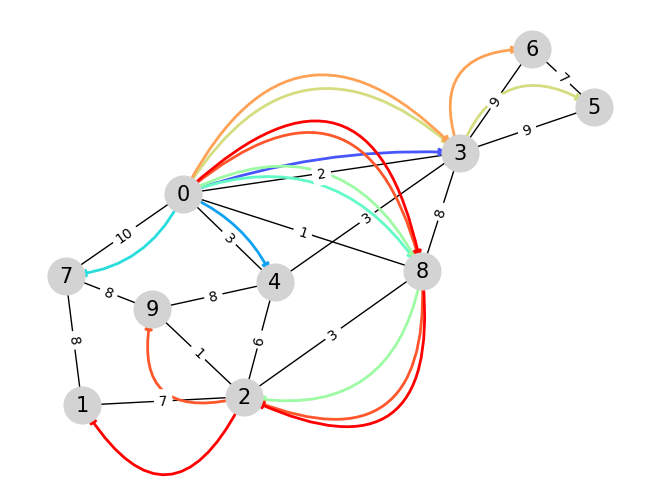

In [10]:
alpha = 0
beta = 1

sol = elegir_algoritmo(alpha, beta, G)

if alpha==0 and beta!=0:
    graficar_alpha_0(sol)

elif alpha!=0 and beta==0:
    graficar_beta_0(sol)

else:
    print('solucion de la parte 2')

##### $\alpha \neq 0$, $\beta=0$

Costo total: 41
Costo tuberías: 41
Costo cables: 0


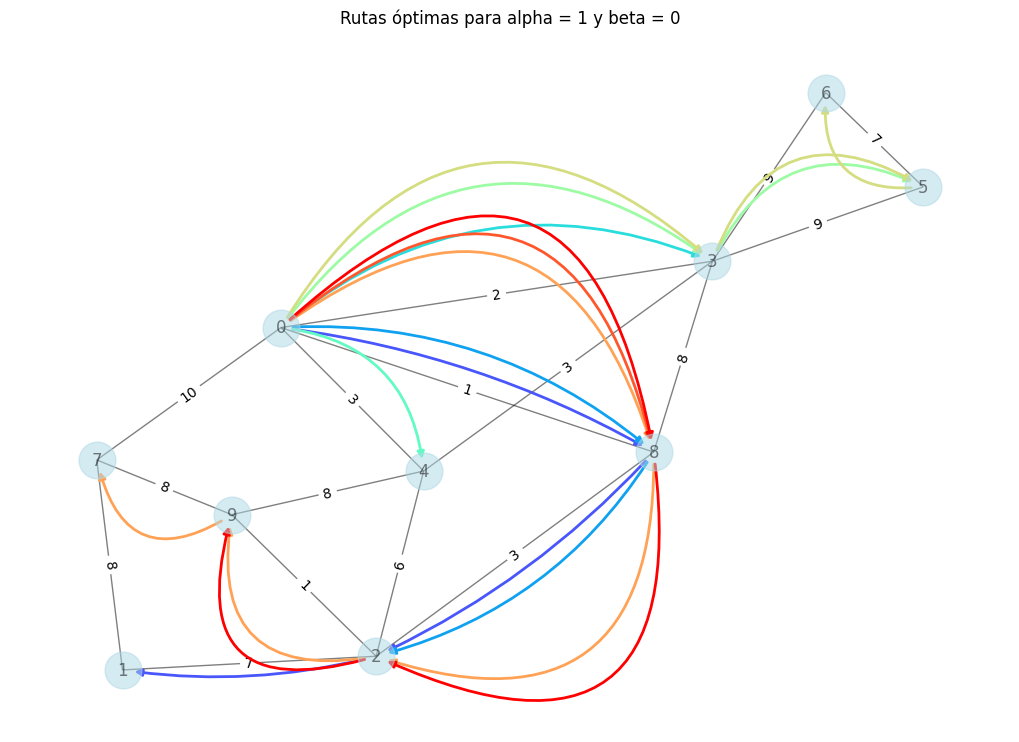

In [11]:
alpha = 1
beta = 0

sol = elegir_algoritmo(alpha, beta, G)

if alpha==0 and beta!=0:
    graficar_alpha_0(sol)

elif alpha!=0 and beta==0:
    graficar_beta_0(sol, alpha)

else:
    print('solucion de la parte 2')

##### $\alpha \neq 0$, $\beta\neq0$

In [12]:
alpha = 1
beta = 1

sol = elegir_algoritmo(alpha, beta, G)


se resolverá en la parte 2


# Parte II

### Mejor algoritmo 

In [13]:
def calcular_costos2(G, alpha, beta, s):
    # inicializamos distancias en infinito y predecesores en -
    distancias = {nodo: float('inf') for nodo in G.nodes}
    previos = {nodo: None for nodo in G.nodes}
    distancias[s] = 0  # distancia inicial al nodo central

    # lista para explorar nodos (simula la cola de prioridad)
    nodos_por_explorar = list(G.nodes)

    while nodos_por_explorar:
        # encontrar el nodo con la distancia mínima entre los nodos por explorar
        nodo_actual = min(nodos_por_explorar, key=lambda nodo: distancias[nodo])

        # removemos el nodo actual de la lista de nodos por explorar
        nodos_por_explorar.remove(nodo_actual)

        # revisamos los vecinos del nodo actual en el que estamos parados
        for vecino in G.neighbors(nodo_actual):
            peso_arista = G[nodo_actual][vecino]['weight']
            nueva_distancia = distancias[nodo_actual] + peso_arista

            # se actualiza la label de distancia si encontramos un camino más corto
            if nueva_distancia < distancias[vecino]:
                distancias[vecino] = nueva_distancia
                previos[vecino] = nodo_actual

    # recuperamos los caminos desde el origen hacia cada nodo
    caminos = {}
    for destino in G.nodes:
        if destino == s:  # nodo central chao pq la ruta es nula
            continue
        camino = []
        nodo_actual = destino
        while nodo_actual is not None:
            camino.append(nodo_actual)
            nodo_actual = previos[nodo_actual]
        caminos[destino] = camino[::-1]  # invertimos el camino para origen -> destino

    # calculamos los costos
    cto_tuberias = 0
    cto_cables = 0

    # encontrar solo los arcos usados (para costo de tuberías)
    arcos_utilizados = set()
    for destino, camino in caminos.items():
        for i in range(len(camino) - 1):  # recorro las aristas del camino
            nodo_a, nodo_b = camino[i], camino[i + 1]
            arcos_utilizados.add((min(nodo_a, nodo_b), max(nodo_a, nodo_b)))

    # sumar los costos de los arcos utilizados (tuberías)
    for u, v in arcos_utilizados:
        cto_tuberias += G[u][v]['weight']

    # costo de los cables: directamente desde el nodo central a cada nodo
    for destino in G.nodes:
        if destino == s:
            continue
        cto_cables += distancias[destino]

    #print(f"Costo de las tuberías sin multiplicar por alpha: {cto_tuberias}")
    #print(f"Costo de los cables sin multiplicar por beta: {cto_cables}")
    
    #costos totales según los factores alpha y beta
    #print(f"Costo de las tuberías multiplicando por alpha: {cto_tuberias*alpha}")
    #print(f"Costo de los cables multiplicando por beta: {cto_cables*beta}")

    # costos totales según los factores alpha y beta
    costo_total = cto_tuberias * alpha + cto_cables * beta
    #print(f"Costo total de la solución: {costo_total}")

    return costo_total, cto_tuberias * alpha, cto_cables * beta, caminos


In [14]:
# ejemplo de instancias
calcular_costos2(G, 0.1, 1, 0)

(62.5,
 4.5,
 58,
 {1: [0, 8, 2, 1],
  2: [0, 8, 2],
  3: [0, 3],
  4: [0, 4],
  5: [0, 3, 5],
  6: [0, 3, 6],
  7: [0, 7],
  8: [0, 8],
  9: [0, 8, 2, 9]})


Evaluando archivo: Parte 2 - Instancia 1.txt
Alpha: 1, Beta: 1, Costo total: 103



Evaluando archivo: Parte 2 - Instancias 2.txt
Alpha: 0, Beta: 1, Costo total: 58


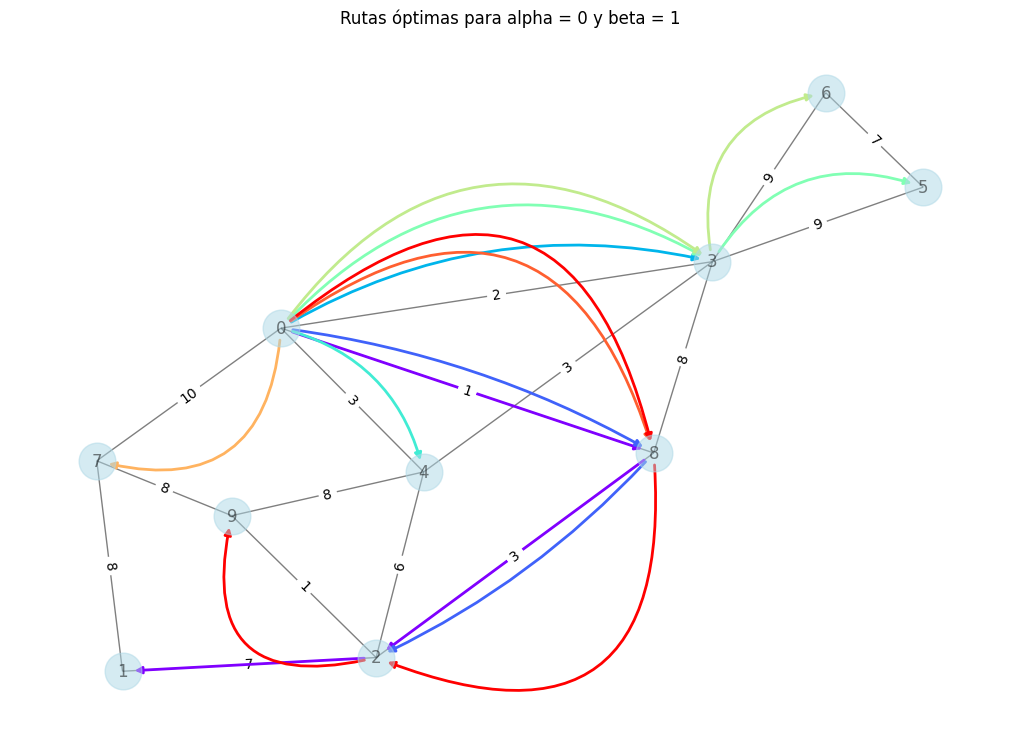

Alpha: 0.1, Beta: 1, Costo total: 62.5


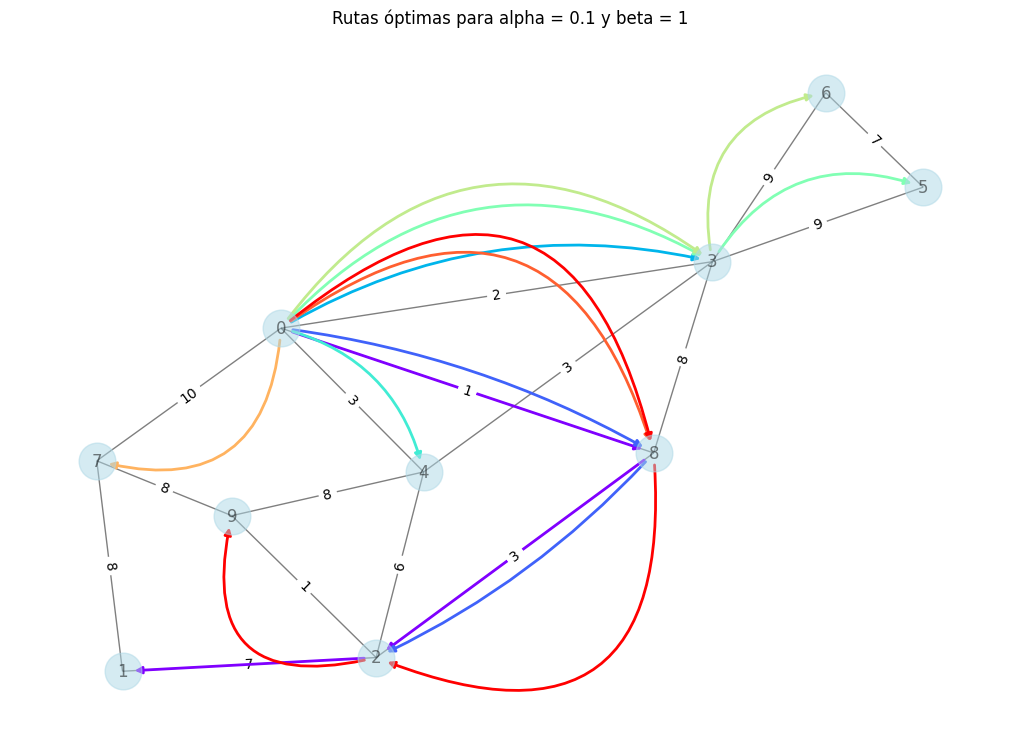

Alpha: 0.1, Beta: 1, Costo total: 62.5


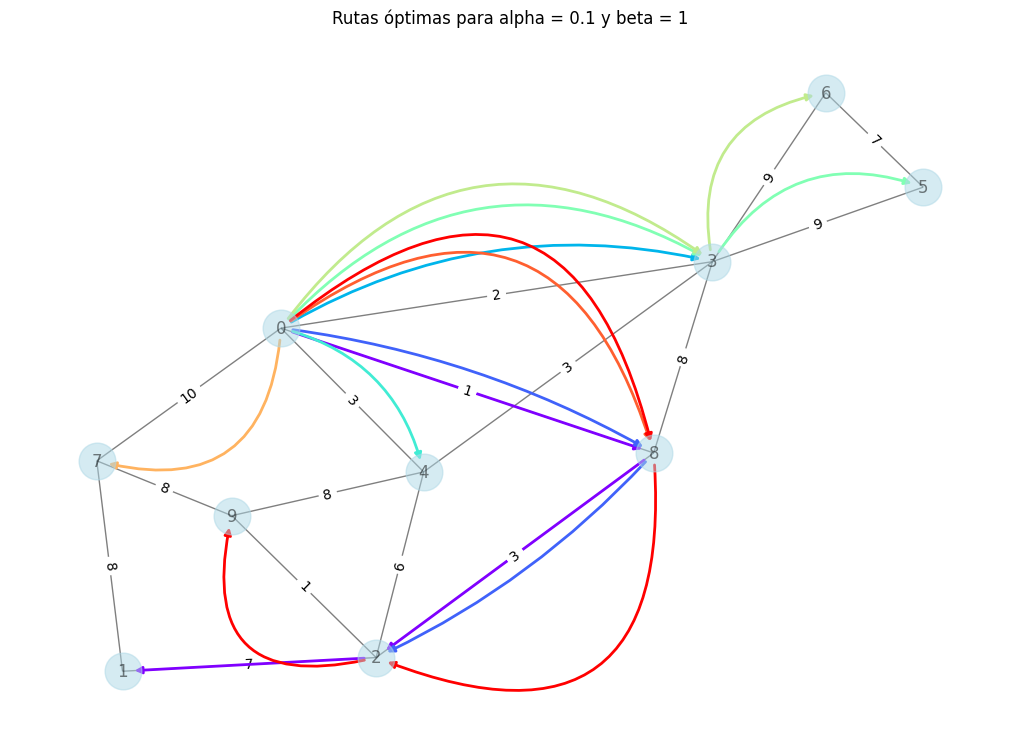

Alpha: 0.2, Beta: 1, Costo total: 67.0


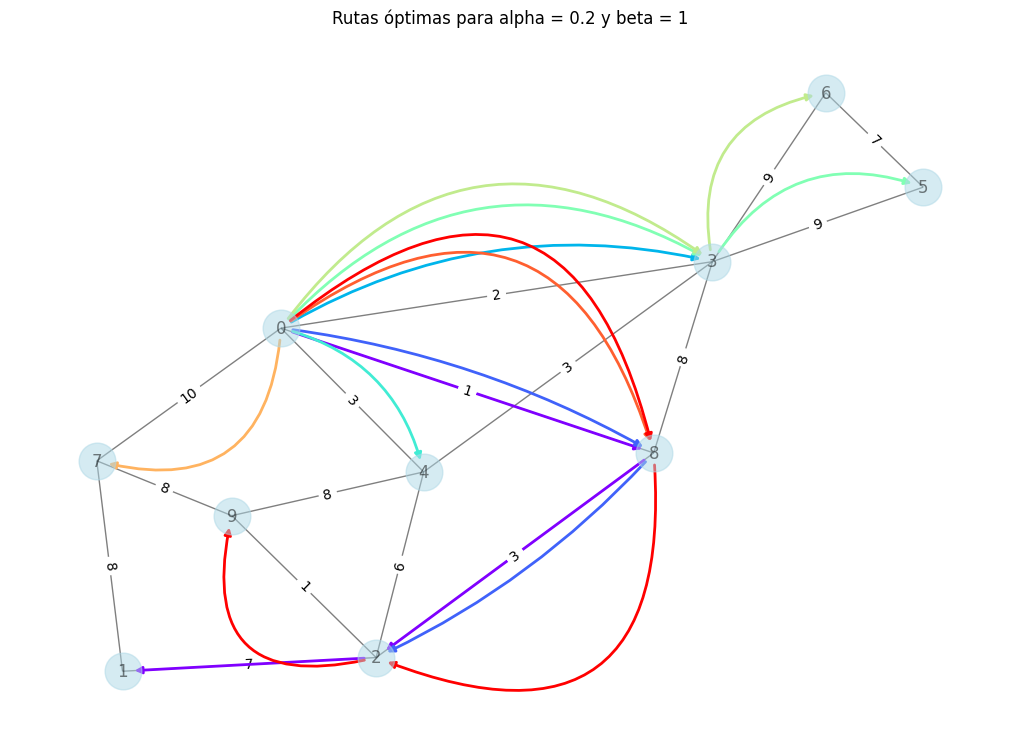

Alpha: 0.3, Beta: 1, Costo total: 71.5


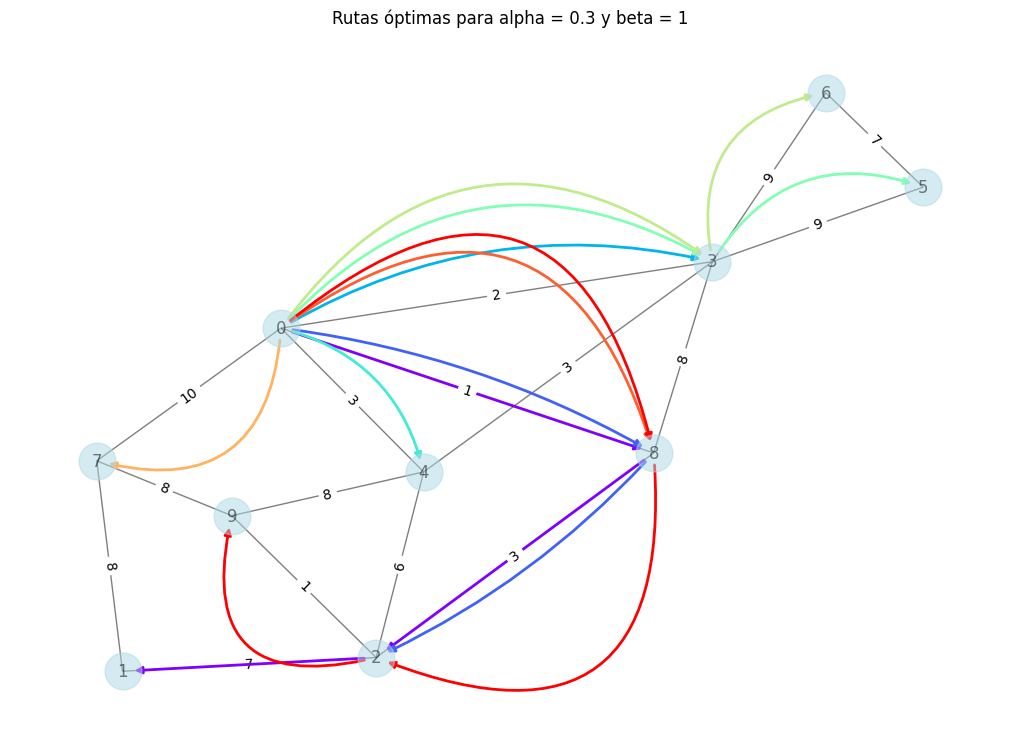

Alpha: 0.5, Beta: 1, Costo total: 80.5


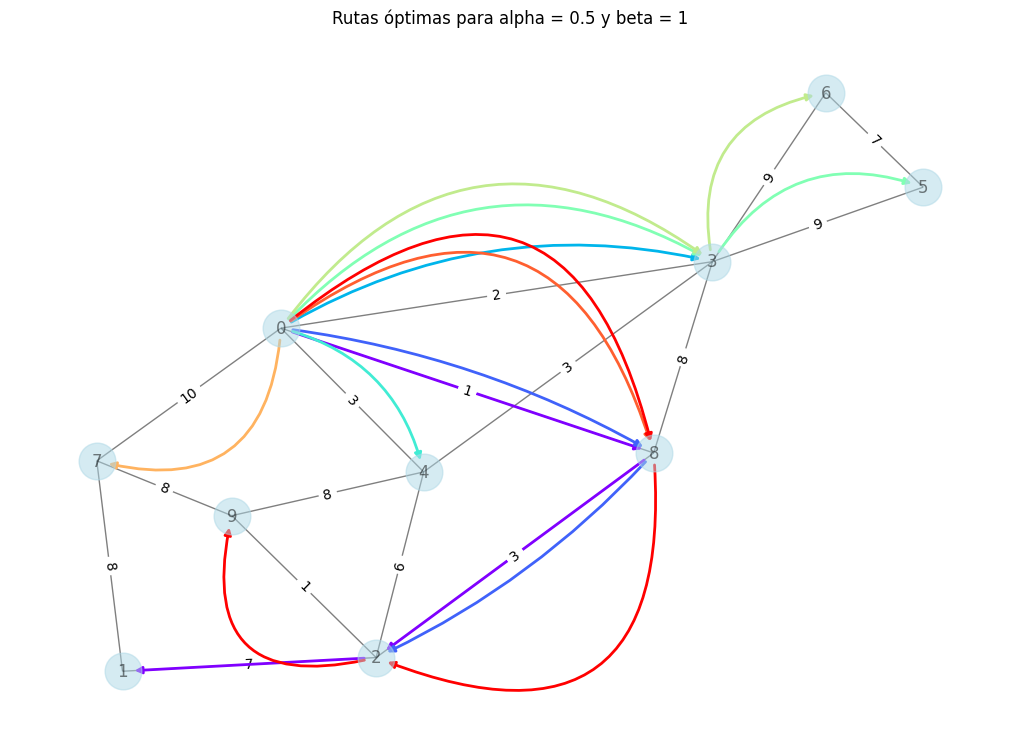

Alpha: 0.8, Beta: 1, Costo total: 94.0


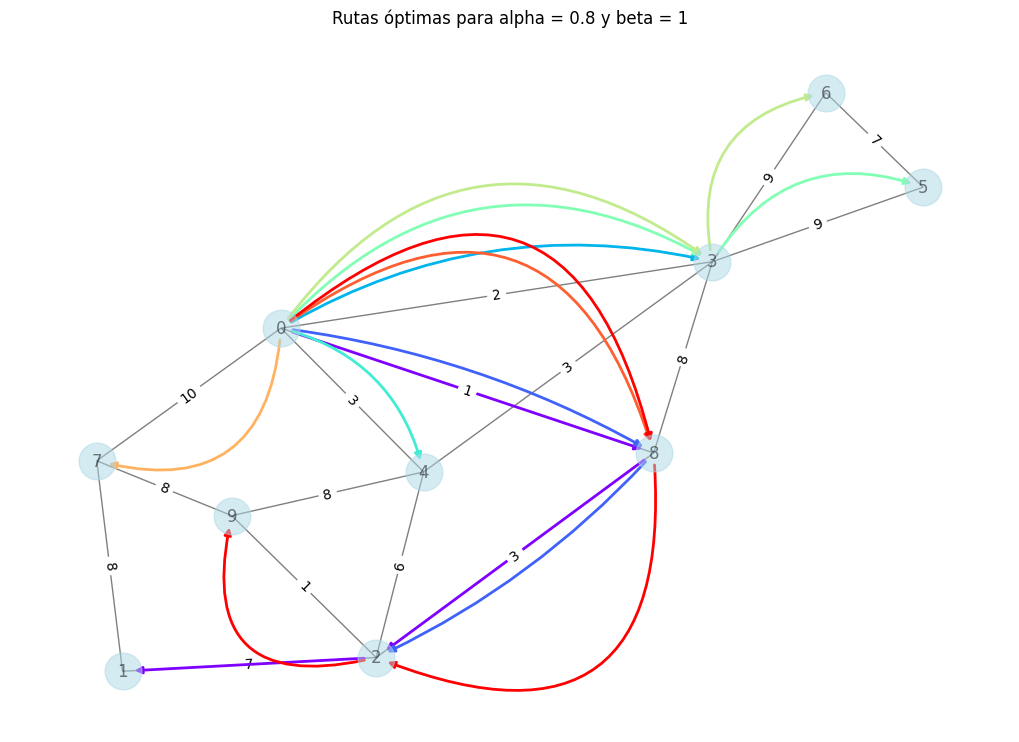

Alpha: 1.3, Beta: 1, Costo total: 116.5


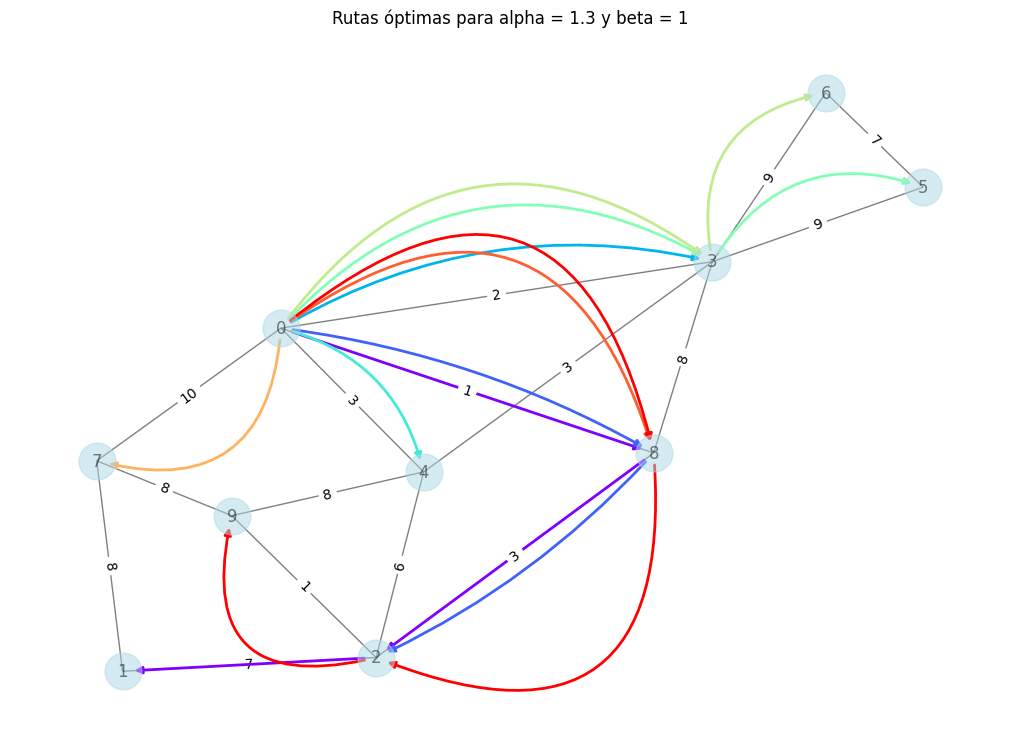

Alpha: 2.1, Beta: 1, Costo total: 152.5


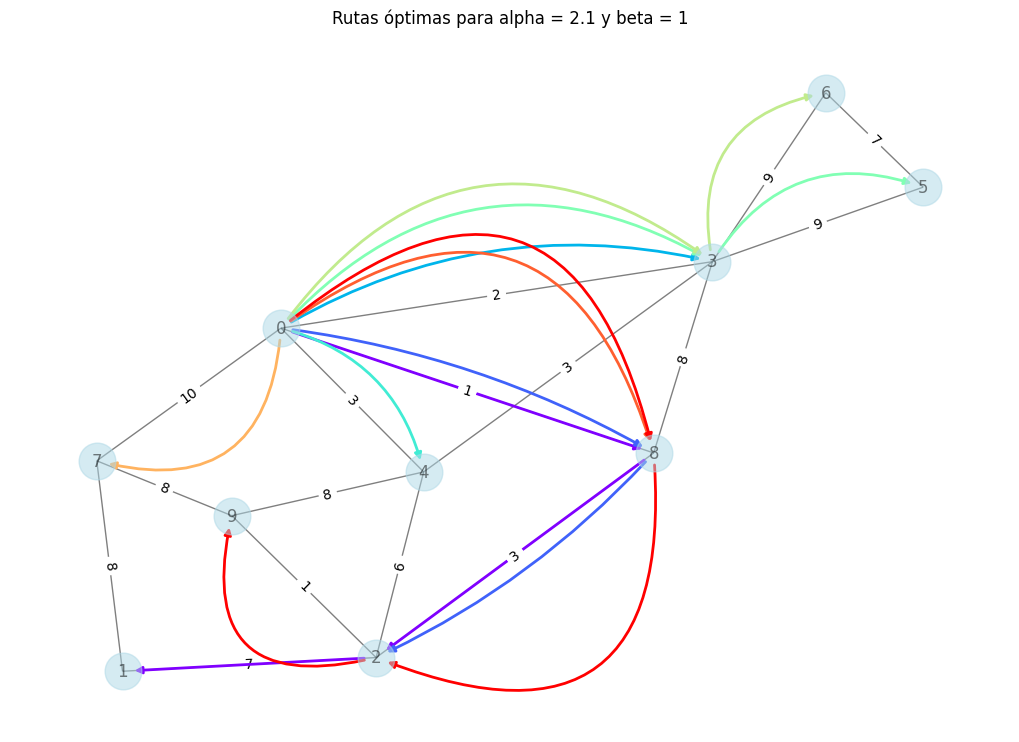

Alpha: 3.4, Beta: 1, Costo total: 211.0


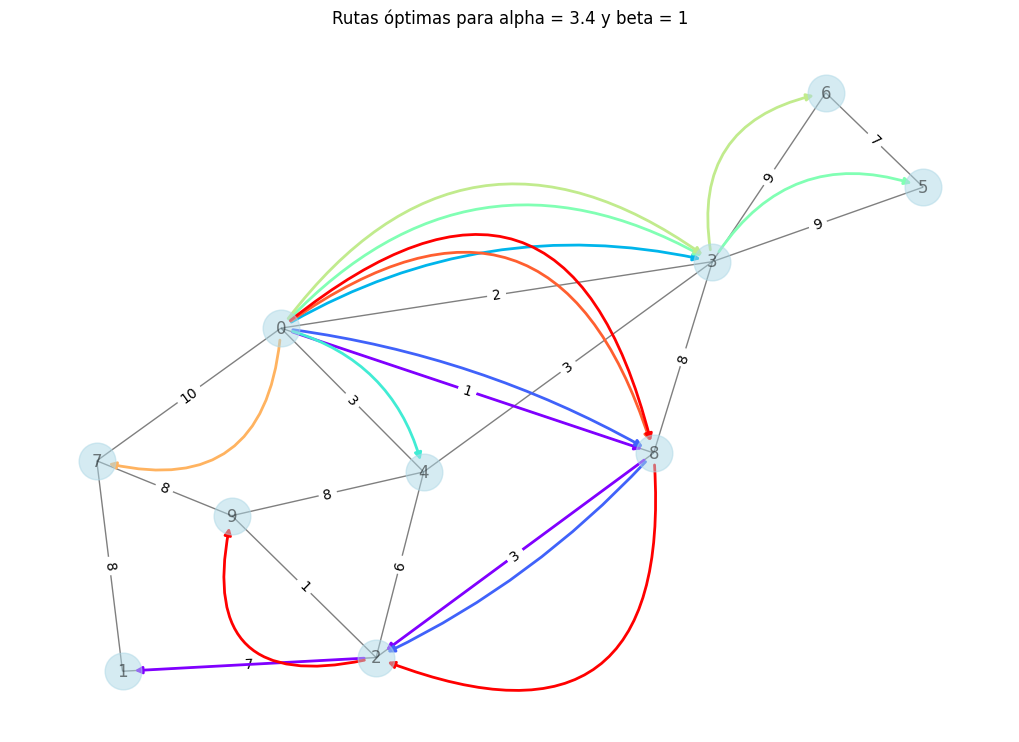

Alpha: 5.5, Beta: 1, Costo total: 305.5


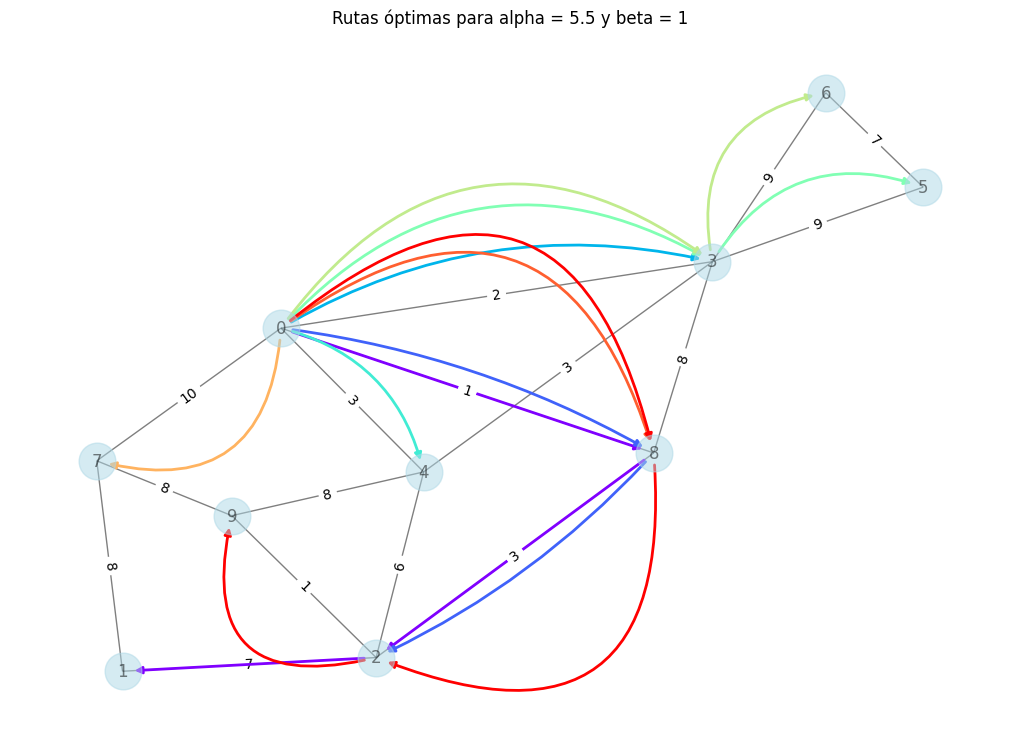

Alpha: 8.9, Beta: 1, Costo total: 458.5


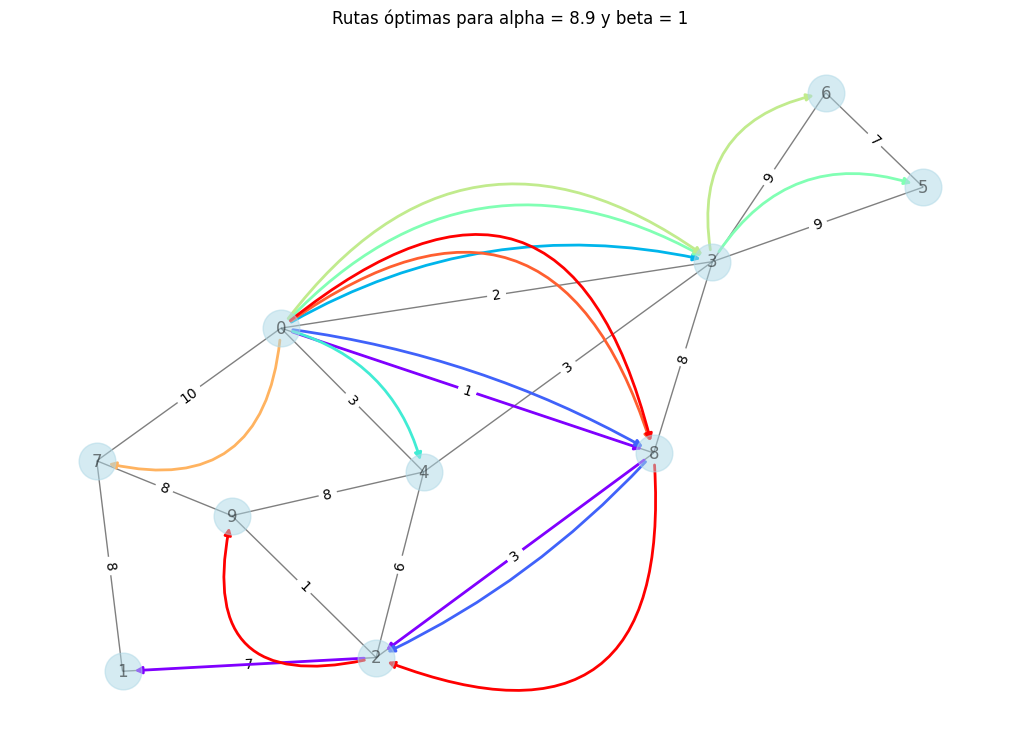

Alpha: 14.4, Beta: 1, Costo total: 706.0


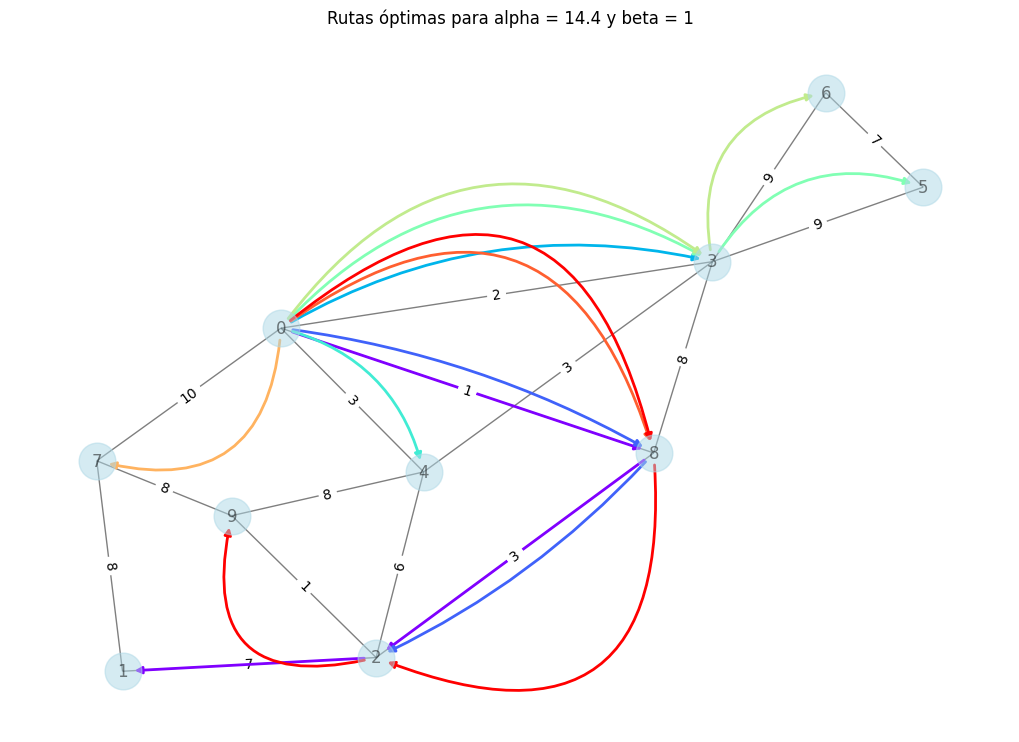

Alpha: 23.3, Beta: 1, Costo total: 1106.5


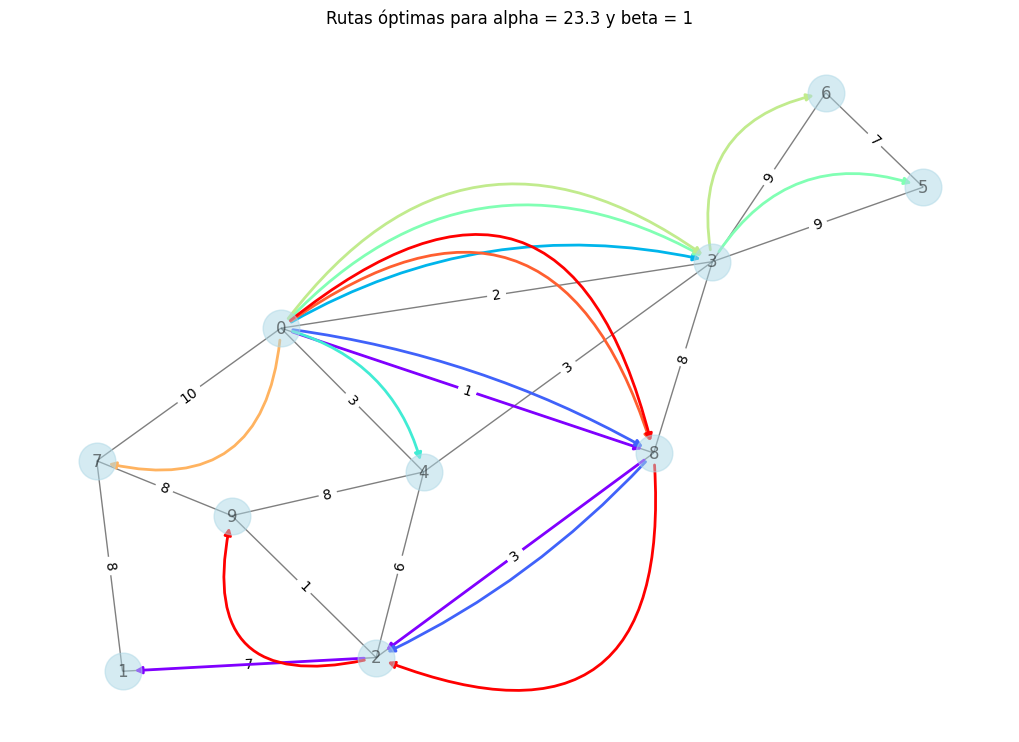

Alpha: 37.7, Beta: 1, Costo total: 1754.5000000000002


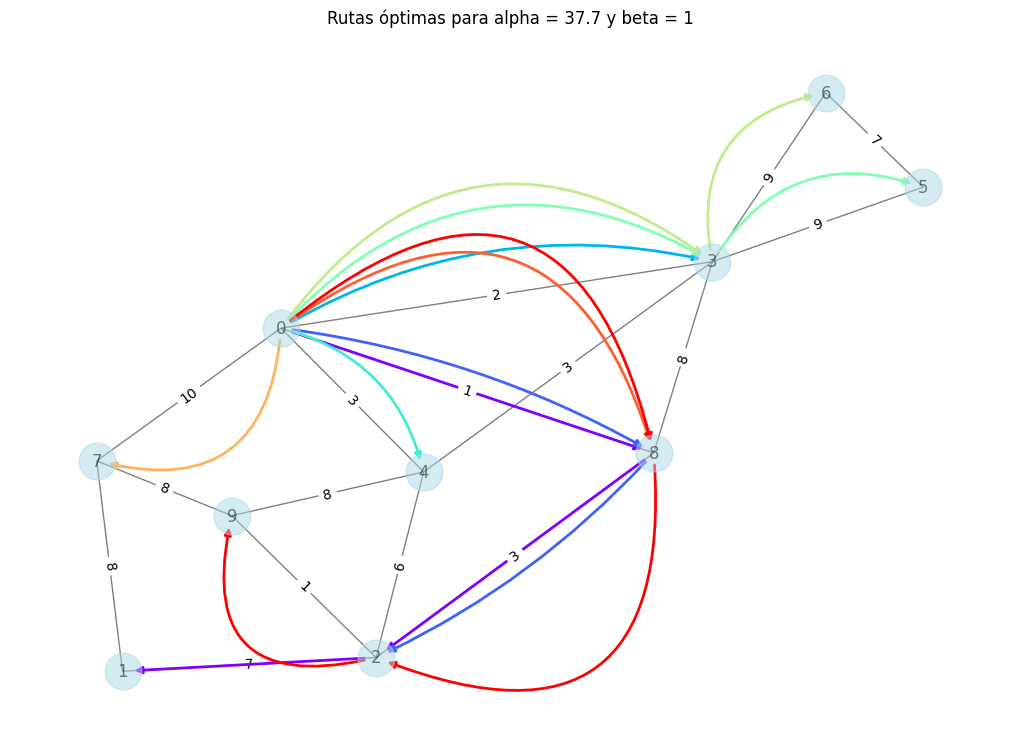

Alpha: 61.0, Beta: 1, Costo total: 2803.0


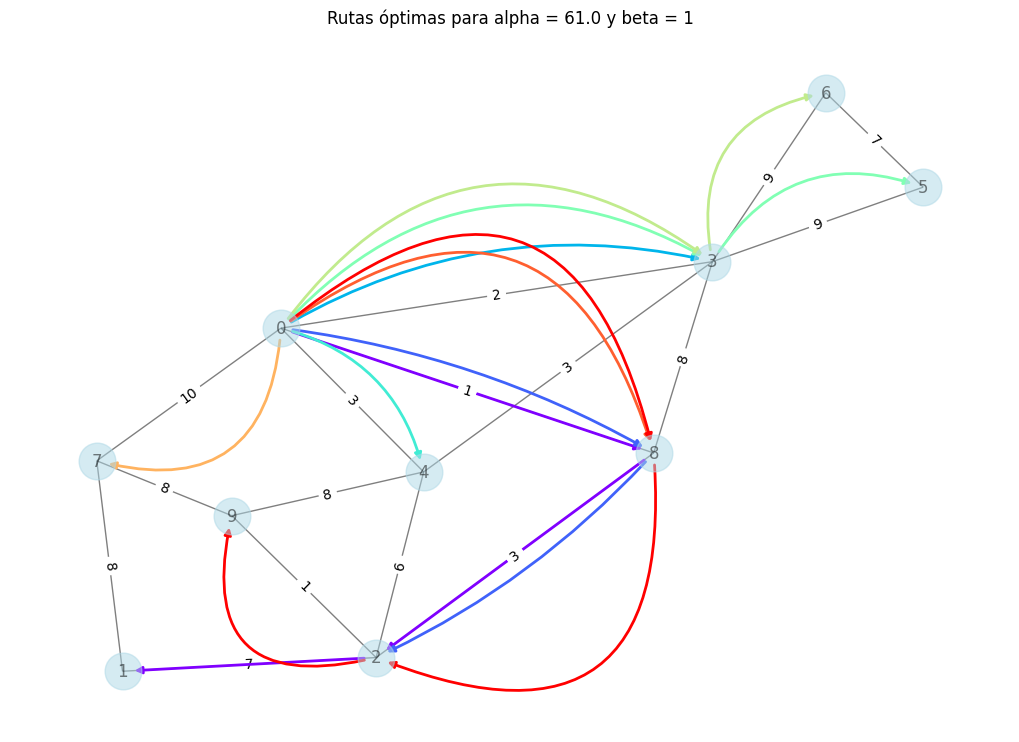

Alpha: 98.7, Beta: 1, Costo total: 4499.5


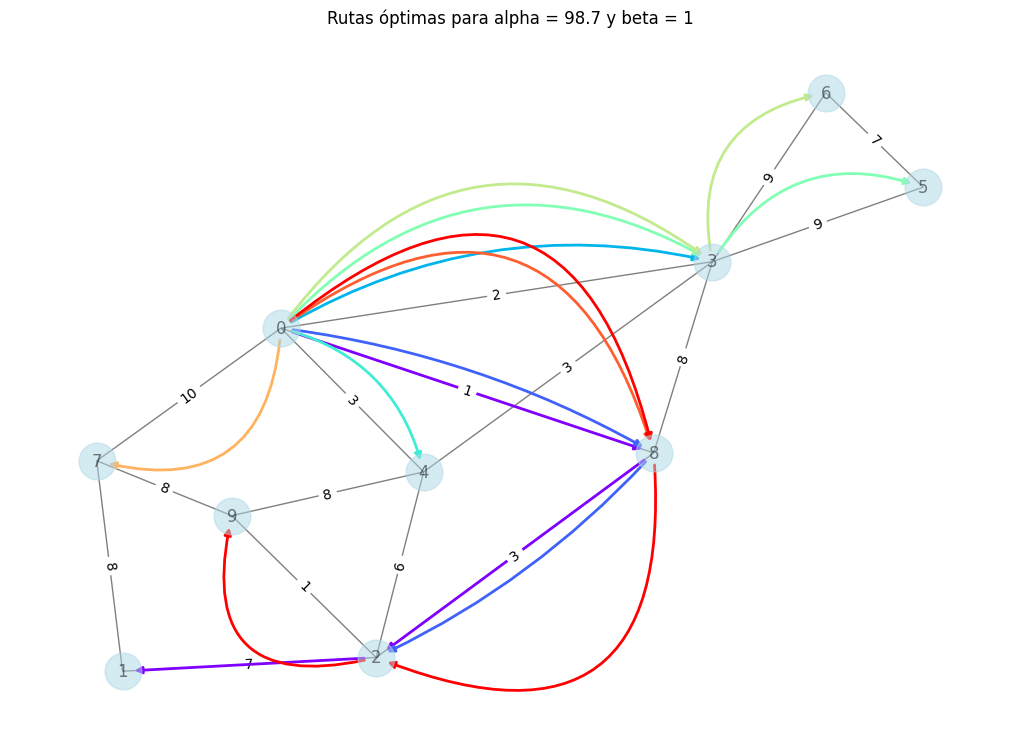

Alpha: 159.7, Beta: 1, Costo total: 7244.499999999999


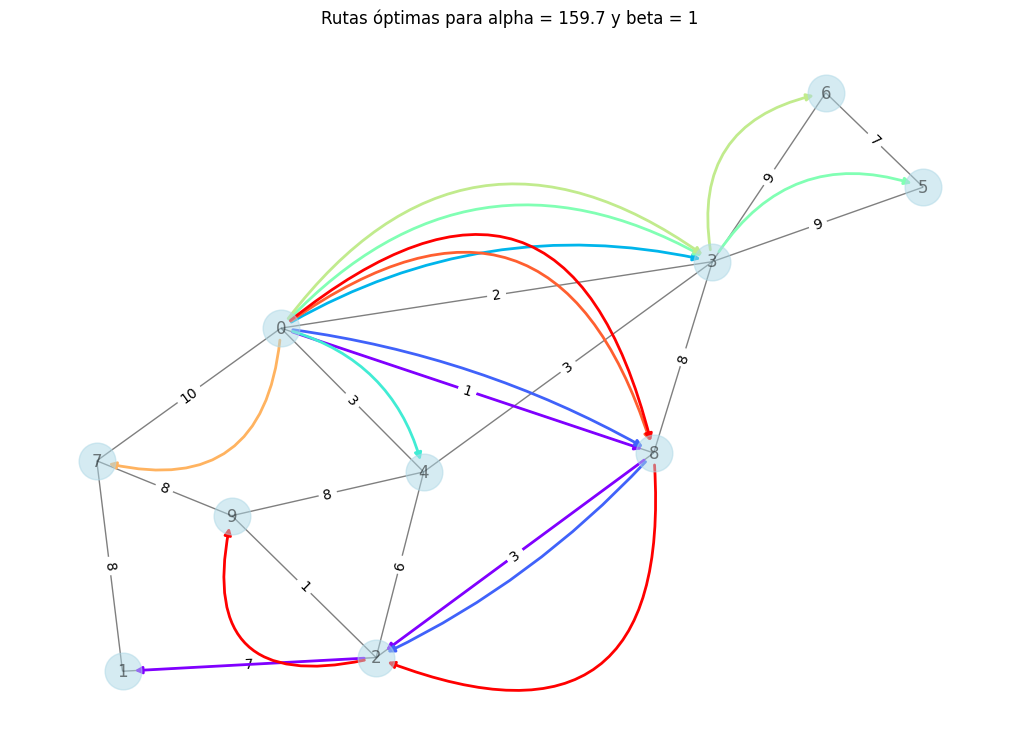

In [15]:
# LECTURA DE INSTANCIAS Y EVALUACION DE TODOS LOS CASOS POSIBLES
#CODIGO CON APOYO DE CHATGPT
def leer_instancias_y_evaluar(ruta_carpeta, archivos_instancias, G, nodo_central):
    for archivo in archivos_instancias:
        ruta_archivo = os.path.join(ruta_carpeta, archivo)
        with open(ruta_archivo, 'r') as f:
            contenido = f.read()
        #extraer valores de alpha y beta
        alphas = eval(contenido.split('alphas = ')[1].split('\n')[0])
        betas = eval(contenido.split('betas = ')[1].split('\n')[0])
        print(f"\nEvaluando archivo: {archivo}")
        for alpha in alphas:
            for beta in betas:
                costo_total, costo_tuberias, costo_cables, caminos = calcular_costos2(G, alpha, beta, nodo_central)
                print(f"Alpha: {alpha}, Beta: {beta}, Costo total: {costo_total}")
                graficar_solucion(G, caminos, nodo_central, alpha, beta)

ruta_carpeta = "Instancias_T3"
archivos_instancias = ["Parte 2 - Instancia 1.txt", "Parte 2 - Instancias 2.txt"]


leer_instancias_y_evaluar(ruta_carpeta, archivos_instancias, G, 0)



# Parte III
Al igual que en las partes anteriosres, vemos los siguientes casos:

### N computadores - $\beta =0$, $\alpha \neq 0$

- veo solo el costo de las tuberías, para esto generaresmo un AMEM y le podaremos los arcos de mayor costo.

In [16]:
def calcular_costos3_beta0(G, alpha, gamma, par):
# encuentro el AMEM del grafo

    AMEM = nx.minimum_spanning_tree(G, algorithm='prim', weight='weight')

    if type(par) is int:
        AMEM_G_costos = sum(d['weight'] for u, v, d in AMEM.edges(data=True))
        costo_compus = gamma
        
    else:
        for a1 in par:
            for a in par:    
                if a1!=a:
                # armo el camino desde nodo1 -> nodo2 y elimino el arco más caro
                    if nx.has_path(AMEM, a1, a) == True:

                        camino_nodo_1_nodo_2 = nx.shortest_path(AMEM, a1, a, 'weight')
                    
                        conexion = nx.DiGraph()

                        # Añadir los arcos basados en la ruta
                        arcos = [(camino_nodo_1_nodo_2[i], camino_nodo_1_nodo_2[i+1]) for i in range(len(camino_nodo_1_nodo_2) - 1)]
                        conexion.add_edges_from(arcos)

                        # elimino el arco de mayor costo entre ambos nodos
                        corte = None
                        maximo = 0

                        for arco in arcos:
                            if G.get_edge_data(arco[0], arco[1])['weight'] > maximo:
                                maximo = G.get_edge_data(arco[0], arco[1])['weight']
                                corte = arco

                        AMEM.remove_edge(*corte)

    # calculo los costos
        AMEM_G_costos = sum(d['weight'] for u, v, d in AMEM.edges(data=True))
        costo_compus = gamma*len(par)

    costo_tuberias = AMEM_G_costos*alpha
    costo_total = costo_compus + costo_tuberias
    costo_cables = 0

    '''print(f'Costo computadores : {costo_compus}')
    print(f'Costo tuberías     : {AMEM_G_costos*alpha}')
    print(f'Costo cables       : 0')
    print(f'Costo total        : {costo_total}')'''

    #return AMEM
    #return AMEM
    #return costo_total, costo_tuberias, costo_cables * beta, costo_compus, caminos
    return costo_total, costo_tuberias, costo_cables, costo_compus

In [17]:
# Ejemplo de instancia
alpha=1
gamma=1
par = (0, 1)

sol = calcular_costos3_beta0(G, alpha, gamma, par)
print(f'Costo computadores : {sol[-1]}')
print(f'Costo tuberías     : {sol[1]*alpha}')
print(f'Costo cables       : {sol[2]}')
print(f'Costo total        : {sol[0]}')

Costo computadores : 2
Costo tuberías     : 34
Costo cables       : 0
Costo total        : 36


### N computadores - $\beta\neq 0$, $\alpha=0$

- veo solo el costo de los cables, para eso veo en cada nodo veo en que caso tiene una menor distancia a los nodos en los que pongo un computador y el que sea menor va a tener conexion a ese computador

In [18]:
def calcular_costos3_alpha0(G, beta, gamma, par):
    destinos = list(G.nodes())
    caminos = dict()
    costoo = 0

    # si solo recibe un nodo la funcion, ejecutamos la funcion de la parte anterior
    if type(par) is int:
        costos = []

        # Calculamos los costos de los caminos más cortos entre pares de nodos usando los pesos
        RM_all_pairs_costo = dict(nx.single_source_dijkstra_path_length(G, par, weight='weight'))

        print(RM_all_pairs_costo)
        
        
        costo_cables = sum(RM_all_pairs_costo.values())

        cto_compus = gamma
        cto_tuberias = 0

        costo_total = cto_compus + costo_cables

        return costo_total, cto_tuberias, costo_cables * beta, cto_compus, caminos

    else:
        # no calculamos las distancias minimas de los computadores a los otros nodos
        for a in par:
            destinos.remove(a)
            caminos[a] = [a]

        # para los edificios sin computador buscamos su computador más cercano
        for nodo in destinos:
            mejor_distancia = float('inf')
            mejor_computador = None
            ruta = None

            for compu in par:
                distancia = nx.shortest_path_length(G, nodo, compu, 'weight')
                if distancia < mejor_distancia:
                    mejor_distancia = distancia
                    mejor_computador = compu
                    ruta = nx.shortest_path(G, nodo, compu, 'weight')

            caminos[nodo] = ruta
            costoo+=mejor_distancia

        arcos = []
        G_solucion = nx.DiGraph()

        # Convertir rutas a arcos
        for ruta in caminos.values():
            if len(ruta) > 1:  # Si hay al menos dos nodos, se pueden formar arcos
                arcos.extend((ruta[i], ruta[i+1]) for i in range(len(ruta) - 1))

        # calculamos los costos
        costo_cables = 0

        for arco in arcos:
            G_solucion.add_edge(*arco, weight=G.get_edge_data(*arco)['weight'])
            costo_cables += G.get_edge_data(*arco)['weight']
        

        costo_compus = gamma*len(par)
        costo_cables = costo_cables*beta
        costo_total = costo_compus + costo_cables
        costo_tuberias = 0
        
        '''
        print(f'Costo computadores : {costo_compus}')
        print(f'Costo tuberías     : 0')
        print(f'Costo cables       : {costo_cables}')
        #print(costoo*beta)
        print(f'Costo total        : {costo_total}')'''

        
        return costo_total, costo_tuberias, costo_cables * beta, costo_compus, caminos
        
        #return G_solucion


In [19]:
# Ejemplo de instancia

par = (5)
sol = calcular_costos3_alpha0(G, 1, 0.2, par)

print(f'Costo computadores : {sol[-2]}')
print(f'Costo tuberías     : {sol[1]}')
print(f'Costo cables       : {sol[2]}')
#print(costoo*beta)
print(f'Costo total        : {sol[0]}')

{5: 0, 6: 7, 3: 9, 0: 11, 4: 12, 8: 12, 2: 15, 9: 16, 7: 21, 1: 22}
Costo computadores : 0.2
Costo tuberías     : 0
Costo cables       : 125
Costo total        : 125.2


### N computadores - caso general

Para esto será necesario ver para cada nodo, desde que edificio se llega con menor costo y asi decidir desde que edificio poner la conexión.

Sirve para n-computadores, $n\in G$.

In [20]:
def varios_nodos_costos(G, alpha, beta, gamma, par):
    cto_tuberias = 0
    cto_cables = 0
    costo_total = 0
    cto_compus = 0
    
    # diccionarios que juntaran los parametros de todos los nodos con computador
    distancias = dict()
    previos = dict()
    revisados = dict()
    nodos_por_explorar = dict()
    caminos = dict()

    # si solo recibe un nodo la funcion, ejecutamos la funcion de la parte anterior
    if type(par) is int:
        costo_total, cto_tuberias, cto_cables, caminos = calcular_costos2(G, alpha, beta, par)
        cto_compus = gamma
        costo_total += cto_compus

        return costo_total, cto_tuberias * alpha, cto_cables * beta, cto_compus, caminos

    # ejecutamos de forma simultanea el algoritmo de la parte anterior a todos los nodos
    else:
        for nodito in par:
            distancias[nodito] = {nodo: float('inf') for nodo in G.nodes}
            previos[nodito] = {nodo: None for nodo in G.nodes}
            distancias[nodito][nodito] = 0                                     # distancia inicial al nodo en el que pongo un computador

            # lista para explorar nodos (simula la cola de prioridad)
            nodos_por_explorar[nodito] = list(G.nodes)
            revisados[nodito] = [nodito]
            caminos[nodito] = dict()

        while all(nodos_por_explorar[key] for key in nodos_por_explorar):
            # Procesar cada lista de nodos en el diccionario
            nodos_actual = {}

            for key, lista_nodos in nodos_por_explorar.items():
                nodos_actual[key] = min(lista_nodos, key=lambda nodo: distancias[key].get(nodo, float('inf')))

            # Remover nodos actuales de cada lista
            for key, nodo_actual in nodos_actual.items():
                nodos_por_explorar[key].remove(nodo_actual)
                revisados[key].append(nodo_actual)

            # Procesar vecinos de cada nodo actual
            for key, nodo_actual in nodos_actual.items():
                for vecino in G.neighbors(nodo_actual):
                    peso_arista = G[nodo_actual][vecino]['weight']
                    nueva_distancia = distancias[key][nodo_actual] + peso_arista

                    menor = min(distancias, key=lambda x: distancias[x][vecino])

                    if nueva_distancia < distancias[key][vecino] and nueva_distancia < distancias[menor][vecino]:
                        distancias[key][vecino] = nueva_distancia
                        previos[key][vecino] = nodo_actual

        for nodito in par:
            for nodo in G.nodes:
                menor = min(distancias, key=lambda x: distancias[x][nodo])

                if distancias[nodito][nodo] > distancias[menor][nodo]:
                    #print(nodito, )
                    distancias[nodito][nodo] = float('inf')
                    previos[nodito][nodo] =  None

        for nodito in par:
            for destino in G.nodes:
                if destino == nodito:  # nodo central chao pq la ruta es nula
                    continue
                camino = []
                nodo_actual = destino

                while nodo_actual is not None:
                    camino.append(nodo_actual)
                    nodo_actual = previos[nodito][nodo_actual]
                caminos[nodito][destino] = camino[::-1]  # invertimos el camino para origen -> destino


        # calculamos los costos
        # encontrar solo los arcos usados (para costo de tuberías)
        arcos_utilizados = set()

        for nodito in par:
            for destino, camino in caminos[nodito].items():
                for i in range(len(camino) - 1):  # recorro las aristas del camino
                    nodo_a, nodo_b = camino[i], camino[i + 1]
                    arcos_utilizados.add((min(nodo_a, nodo_b), max(nodo_a, nodo_b)))


        # sumar los costos de los arcos utilizados (tuberías)
        for u, v in arcos_utilizados:
            cto_tuberias += G[u][v]['weight']

        # costo de los cables: directamente desde el nodo central a cada nodo
        for nodito in par:
            for destino in G.nodes:
                if destino == nodito:
                    continue
                
                if distancias[nodito][destino] != float('inf'):
                    cto_cables += distancias[nodito][destino]

        cto_compus = len(par) * gamma
        costo_total = cto_tuberias * alpha + cto_cables * beta + cto_compus

        return costo_total, cto_tuberias * alpha, cto_cables * beta, cto_compus, caminos

In [21]:
# ejemplo de instancia
varios_nodos_costos(G, 0,1,1,(5))

(126,
 0,
 125,
 1,
 {0: [5, 3, 0],
  1: [5, 3, 0, 8, 2, 1],
  2: [5, 3, 0, 8, 2],
  3: [5, 3],
  4: [5, 3, 4],
  6: [5, 6],
  7: [5, 3, 0, 7],
  8: [5, 3, 0, 8],
  9: [5, 3, 0, 8, 2, 9]})

* NOTA MENTAL: no revisamos que el costo global sea mejor cuando iteramos pq si tengo ya la mejor ruta a un nodo, el costo a ese nodo ya sera el mejor y por consecuencia no puede mejorar mucho más la solución.

### Análisis sensibilidad y ejecucion de instancias

In [22]:
# conjunto de combinaciones posibles de nodos

nodos = list(G.nodes())
combinaciones = []
for a in range(2, G.number_of_nodes()+1):
    combinaciones.append(list(itertools.combinations(nodos, a)))
combinaciones.insert(0,nodos)

In [23]:
# FUNCIONES PARA DETERMINAR MEJORES RESULTADOS (COSTOS MENORES)

# mejores combinaciones de numero de nodos
def mejores_costos_combinaciones(alpha, beta, gamma, G):
    print('===================================================='.center(50))
    print(f'alpha={alpha}, beta={beta}, gamma={gamma}'.center(50))
    print('===================================================='.center(50))
    for num_comb in range(2, len(combinaciones)+1):        
        dict_costos_totales = {}
        dict_solucion = {}

        for par in combinaciones[num_comb-1]:
            dict_costos_totales[par] = varios_nodos_costos(G, alpha, beta, gamma, par)[0]
            dict_solucion[par] = varios_nodos_costos(G, alpha, beta, gamma, par)

        par_menor_costo = min(dict_costos_totales,  key=dict_costos_totales.get)

        #print(dict_costos_totales)
        
        print(f'Combinaciones de {num_comb} nodos'.center(50))
        print('-------------------------------------')
        
        print(f'\nNodos              : {par_menor_costo}')

        
        print(f'Costo Tuberias     : {dict_solucion[par_menor_costo][1]}')
        print(f'Costo Cables       : {dict_solucion[par_menor_costo][2]}')
        print(f'Costo Computadores : {dict_solucion[par_menor_costo][3]}')
        print('_____________________________________')
        print(f'Costo Total        : {dict_solucion[par_menor_costo][0]}\n')



# mejor numero de computadores para una combinacion de alpha, beta y gamma
def mejores_costos_intancia(alpha, beta, gamma, G):
    mejor_costo = float('inf')
    mejor_par = None
    mejores_resultados = None

    if alpha==0 and beta>0:
        for num_comb in range(2, len(combinaciones)+1):        
            dict_costos_totales = {}
            dict_solucion = {}

            for par in combinaciones[num_comb-1]:
                dict_costos_totales[par] = calcular_costos3_alpha0(G, beta, gamma, par)[0]
                dict_solucion[par] = calcular_costos3_alpha0(G, beta, gamma, par)

            # ve el menor costo de ese numero de combinaciones de nodos
            mejor_par_comb = min(dict_costos_totales,  key=dict_costos_totales.get)
            
            cto = dict_costos_totales[mejor_par_comb]

            if cto < mejor_costo:
                mejor_costo = cto
                mejor_par = mejor_par_comb
                mejores_resultados = dict_solucion[mejor_par_comb]

    
    elif alpha>0 and beta==0:
        for num_comb in range(2, len(combinaciones)+1):        
            dict_costos_totales = {}
            dict_solucion = {}

            for par in combinaciones[num_comb-1]:
                dict_costos_totales[par] = calcular_costos3_beta0(G, alpha, gamma, par)[0]
                dict_solucion[par] = calcular_costos3_beta0(G, alpha, gamma, par)

            # ve el menor costo de ese numero de combinaciones de nodos
            mejor_par_comb = min(dict_costos_totales,  key=dict_costos_totales.get)
            
            cto = dict_costos_totales[mejor_par_comb]

            if cto < mejor_costo:
                mejor_costo = cto
                mejor_par = mejor_par_comb
                mejores_resultados = dict_solucion[mejor_par_comb]
    
    elif alpha>0 and beta>0:
        for num_comb in range(1, len(combinaciones)+1):        
            dict_costos_totales = {}
            dict_solucion = {}

            for par in combinaciones[num_comb-1]:
                dict_costos_totales[par] = varios_nodos_costos(G, alpha, beta, gamma, par)[0]
                dict_solucion[par] = varios_nodos_costos(G, alpha, beta, gamma, par)

            # ve el menor costo de ese numero de combinaciones de nodos
            mejor_par_comb = min(dict_costos_totales,  key=dict_costos_totales.get)
            
            cto = dict_costos_totales[mejor_par_comb]

            if cto < mejor_costo:
                mejor_costo = cto
                mejor_par = mejor_par_comb
                mejores_resultados = dict_solucion[mejor_par_comb]

    print(f'alpha={alpha}, beta={beta}, gamma={gamma}'.center(30))
    print('___________________________________________')
    print(f'Nodos: {mejor_par}')

    print(f'\nCosto Tuberías      : {mejores_resultados[1]}')
    print(f'Costo Cables        : {mejores_resultados[2]}')
    print(f'Costo Computadores  : {mejores_resultados[3]}')
    print('___________________________________________')
    print(f'Costo Total         : {mejores_resultados[0]}')
        

#### Instancias 1

In [24]:
# instancia 1
carpeta_instancias = "./Instancias_T3"
archivo = f"{carpeta_instancias}/Parte 3 - Instancias 1.txt"

with open(archivo, 'r') as f:
    alphas = eval(f.readline().split('=')[1].strip())
    betas = eval(f.readline().split('=')[1].strip())
    gammas = eval(f.readline().split('=')[1].strip())
    
# en correrlo todo todo se demora 20 segundos, podriamos hacer graficos con esto
for alpha in alphas:
    for beta in betas:
        for gamma in gammas:
            mejores_costos_intancia(alpha, beta, gamma, G)
            print('\n')

   alpha=0, beta=1, gamma=0   
___________________________________________
Nodos: (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)

Costo Tuberías      : 0
Costo Cables        : 0
Costo Computadores  : 0
___________________________________________
Costo Total         : 0


  alpha=0, beta=1, gamma=0.2  
___________________________________________
Nodos: (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)

Costo Tuberías      : 0
Costo Cables        : 0
Costo Computadores  : 2.0
___________________________________________
Costo Total         : 2.0


  alpha=0, beta=1, gamma=0.4  
___________________________________________
Nodos: (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)

Costo Tuberías      : 0
Costo Cables        : 0
Costo Computadores  : 4.0
___________________________________________
Costo Total         : 4.0


  alpha=0, beta=1, gamma=0.8  
___________________________________________
Nodos: (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)

Costo Tuberías      : 0
Costo Cables        : 0
Costo Computadores  : 8.0
____________________________________

In [25]:
# en correrlo todo todo se demora 20 segundos, podriamos hacer graficos con esto
for alpha in alphas:
    for beta in betas:
        for gamma in gammas:
            mejores_costos_combinaciones(alpha, beta, gamma, G)

             alpha=0, beta=1, gamma=0             
             Combinaciones de 2 nodos             
-------------------------------------

Nodos              : (0, 5)
Costo Tuberias     : 0
Costo Cables       : 43
Costo Computadores : 0
_____________________________________
Costo Total        : 43

             Combinaciones de 3 nodos             
-------------------------------------

Nodos              : (0, 1, 5)
Costo Tuberias     : 0
Costo Cables       : 30
Costo Computadores : 0
_____________________________________
Costo Total        : 30

             Combinaciones de 4 nodos             
-------------------------------------

Nodos              : (0, 2, 5, 7)
Costo Tuberias     : 0
Costo Cables       : 21
Costo Computadores : 0
_____________________________________
Costo Total        : 21

             Combinaciones de 5 nodos             
-------------------------------------

Nodos              : (0, 1, 2, 5, 7)
Costo Tuberias     : 0
Costo Cables       : 14
Costo Computa

#### Instancias 2

In [26]:
# instancia 2
carpeta_instancias = "./Instancias_T3"
archivo = f"{carpeta_instancias}/Parte 3 - Instancias 2.txt"

with open(archivo, 'r') as f:
    alphas = eval(f.readline().split('=')[1].strip())
    betas = eval(f.readline().split('=')[1].strip())
    gammas = eval(f.readline().split('=')[1].strip())
    
# en correrlo todo todo se demora 20 segundos, podriamos hacer graficos con esto
for alpha in alphas:
    for beta in betas:
        for gamma in gammas:
            mejores_costos_intancia(alpha, beta, gamma, G)
            print('\n')

   alpha=1, beta=0, gamma=0   
___________________________________________
Nodos: (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)

Costo Tuberías      : 0
Costo Cables        : 0
Costo Computadores  : 0
___________________________________________
Costo Total         : 0


  alpha=1, beta=0, gamma=0.2  
___________________________________________
Nodos: (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)

Costo Tuberías      : 0
Costo Cables        : 0
Costo Computadores  : 2.0
___________________________________________
Costo Total         : 2.0


  alpha=1, beta=0, gamma=0.4  
___________________________________________
Nodos: (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)

Costo Tuberías      : 0
Costo Cables        : 0
Costo Computadores  : 4.0
___________________________________________
Costo Total         : 4.0


  alpha=1, beta=0, gamma=0.8  
___________________________________________
Nodos: (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)

Costo Tuberías      : 0
Costo Cables        : 0
Costo Computadores  : 8.0
____________________________________

In [27]:
# en correrlo todo todo se demora 20 segundos, podriamos hacer graficos con esto
for alpha in alphas:
    for beta in betas:
        for gamma in gammas:
            mejores_costos_combinaciones(alpha, beta, gamma, G)

             alpha=1, beta=0, gamma=0             
             Combinaciones de 2 nodos             
-------------------------------------

Nodos              : (0, 5)
Costo Tuberias     : 34
Costo Cables       : 0
Costo Computadores : 0
_____________________________________
Costo Total        : 34

             Combinaciones de 3 nodos             
-------------------------------------

Nodos              : (0, 1, 5)
Costo Tuberias     : 25
Costo Cables       : 0
Costo Computadores : 0
_____________________________________
Costo Total        : 25

             Combinaciones de 4 nodos             
-------------------------------------

Nodos              : (0, 1, 5, 7)
Costo Tuberias     : 17
Costo Cables       : 0
Costo Computadores : 0
_____________________________________
Costo Total        : 17

             Combinaciones de 5 nodos             
-------------------------------------

Nodos              : (0, 1, 5, 6, 7)
Costo Tuberias     : 10
Costo Cables       : 0
Costo Computa

#### Instancias 3

In [28]:
# instancia 2
carpeta_instancias = "./Instancias_T3"
archivo = f"{carpeta_instancias}/Parte 3 - Instancias 3.txt"

with open(archivo, 'r') as f:
    alphas = eval(f.readline().split('=')[1].strip())
    betas = eval(f.readline().split('=')[1].strip())
    gammas = eval(f.readline().split('=')[1].strip())
    
# en correrlo todo todo se demora 20 segundos, podriamos hacer graficos con esto
for alpha in alphas:
    for beta in betas:
        for gamma in gammas:
            mejores_costos_intancia(alpha, beta, gamma, G)
            print('\n')

   alpha=1, beta=1, gamma=0   
___________________________________________
Nodos: (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)

Costo Tuberías      : 0
Costo Cables        : 0
Costo Computadores  : 0
___________________________________________
Costo Total         : 0


  alpha=1, beta=1, gamma=0.2  
___________________________________________
Nodos: (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)

Costo Tuberías      : 0
Costo Cables        : 0
Costo Computadores  : 2.0
___________________________________________
Costo Total         : 2.0


  alpha=1, beta=1, gamma=0.4  
___________________________________________
Nodos: (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)

Costo Tuberías      : 0
Costo Cables        : 0
Costo Computadores  : 4.0
___________________________________________
Costo Total         : 4.0


  alpha=1, beta=1, gamma=0.8  
___________________________________________
Nodos: (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)

Costo Tuberías      : 0
Costo Cables        : 0
Costo Computadores  : 8.0
____________________________________

In [29]:
# en correrlo todo todo se demora 20 segundos, podriamos hacer graficos con esto
for alpha in alphas:
    for beta in betas:
        for gamma in gammas:
            mejores_costos_combinaciones(alpha, beta, gamma, G)

             alpha=1, beta=1, gamma=0             
             Combinaciones de 2 nodos             
-------------------------------------

Nodos              : (0, 5)
Costo Tuberias     : 34
Costo Cables       : 43
Costo Computadores : 0
_____________________________________
Costo Total        : 77

             Combinaciones de 3 nodos             
-------------------------------------

Nodos              : (0, 1, 5)
Costo Tuberias     : 25
Costo Cables       : 30
Costo Computadores : 0
_____________________________________
Costo Total        : 55

             Combinaciones de 4 nodos             
-------------------------------------

Nodos              : (0, 1, 5, 7)
Costo Tuberias     : 17
Costo Cables       : 22
Costo Computadores : 0
_____________________________________
Costo Total        : 39

             Combinaciones de 5 nodos             
-------------------------------------

Nodos              : (0, 1, 5, 6, 7)
Costo Tuberias     : 10
Costo Cables       : 15
Costo Com

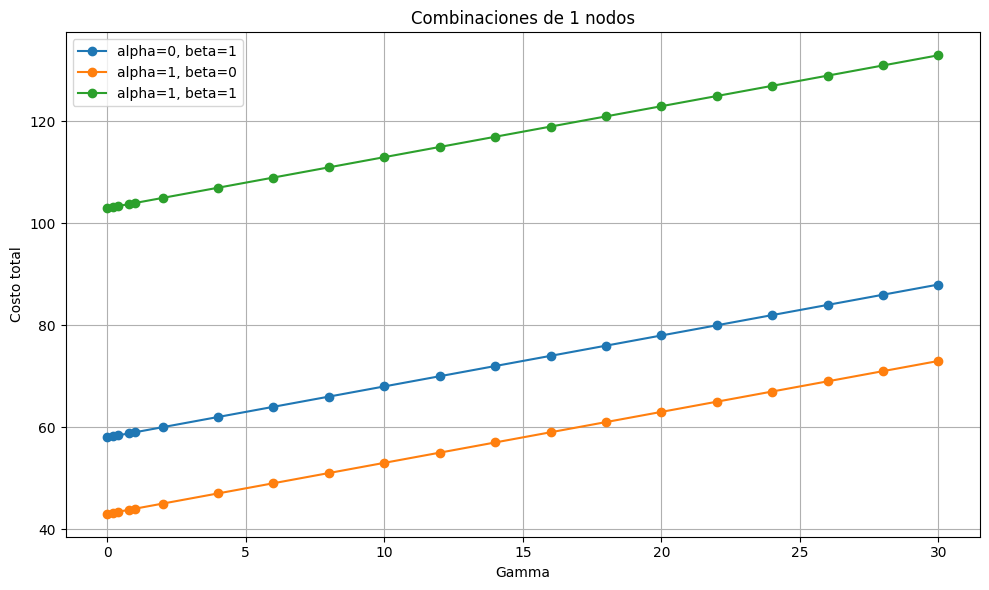

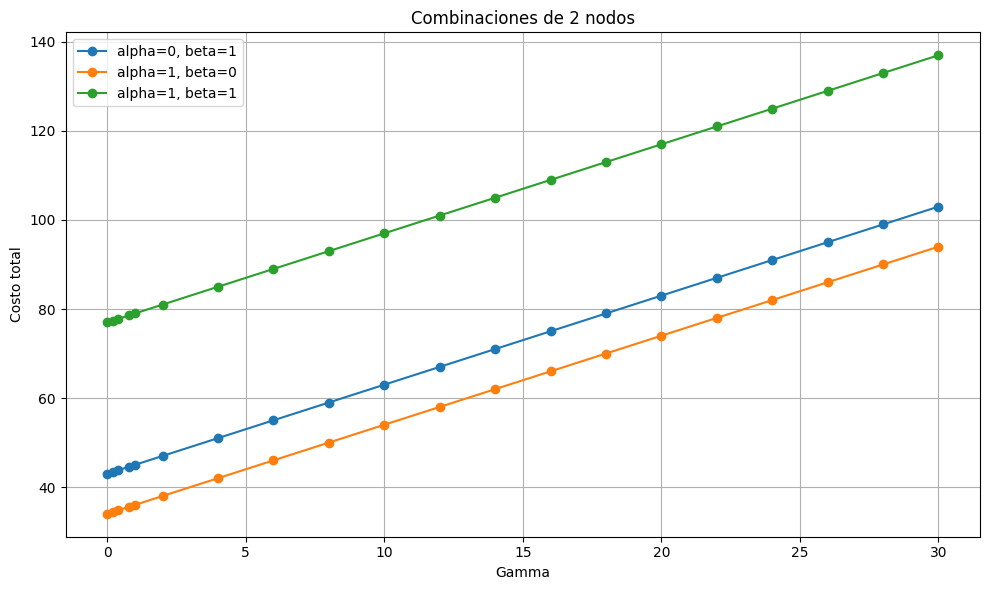

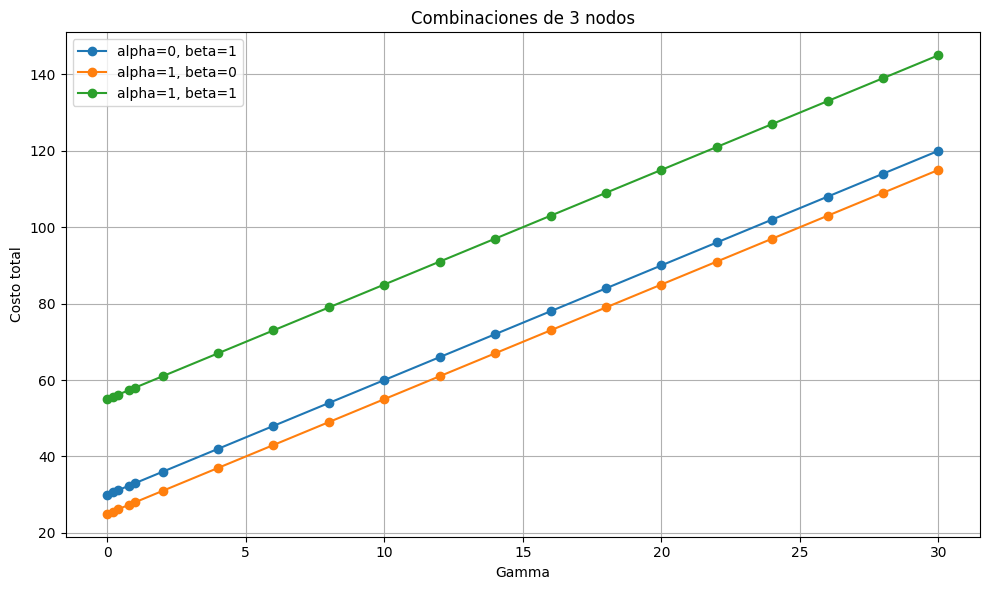

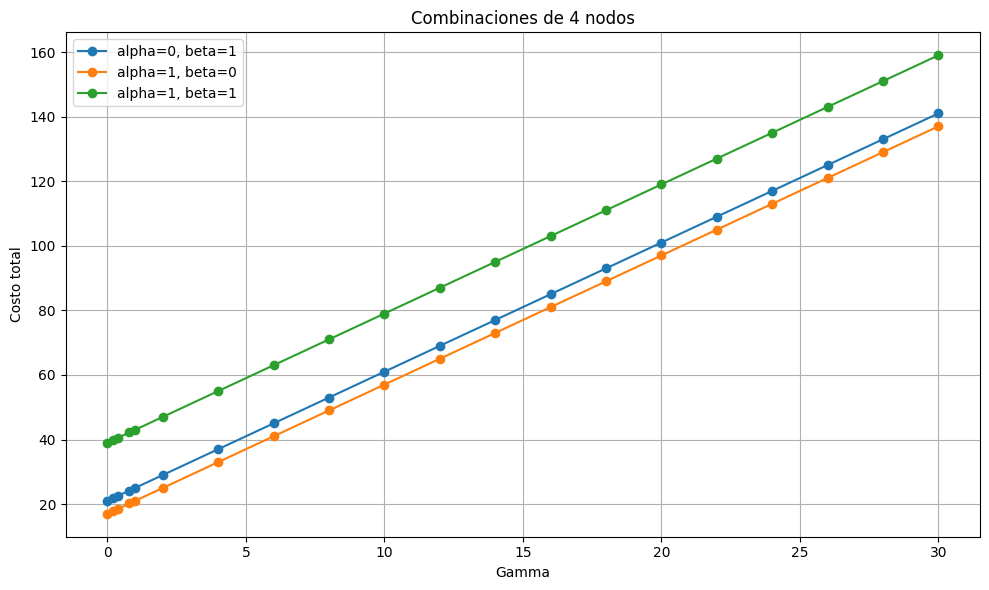

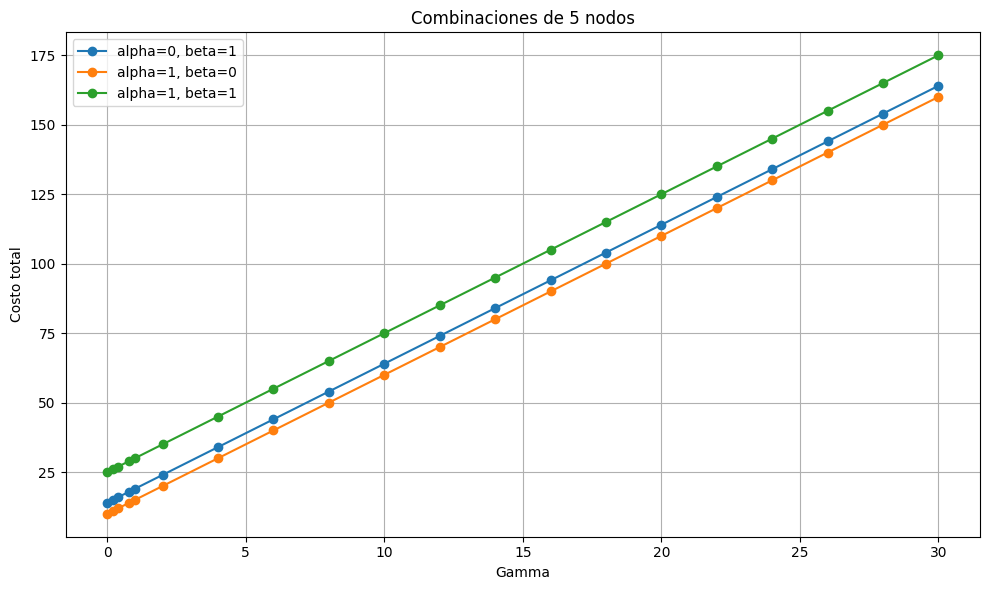

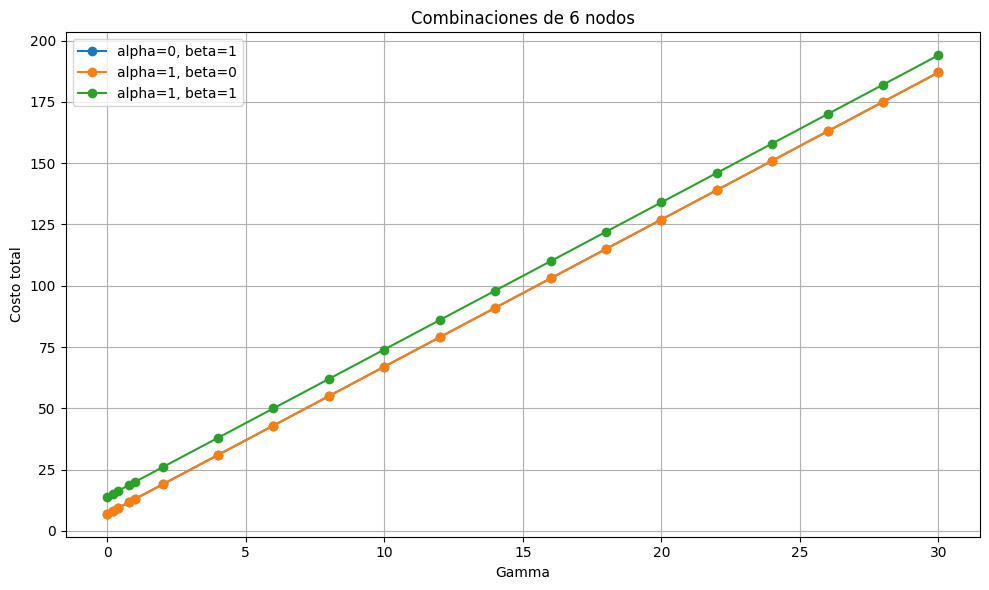

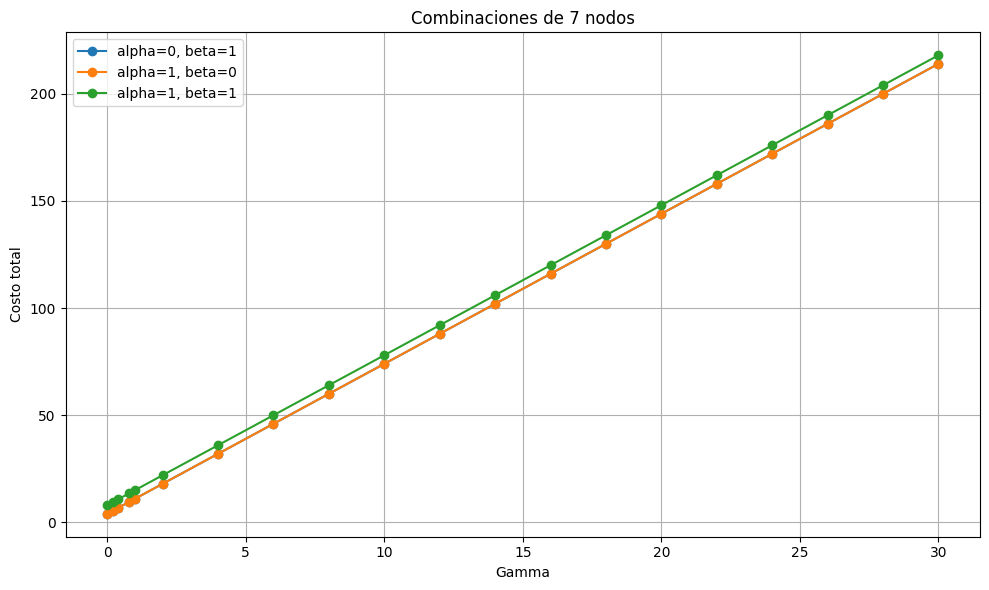

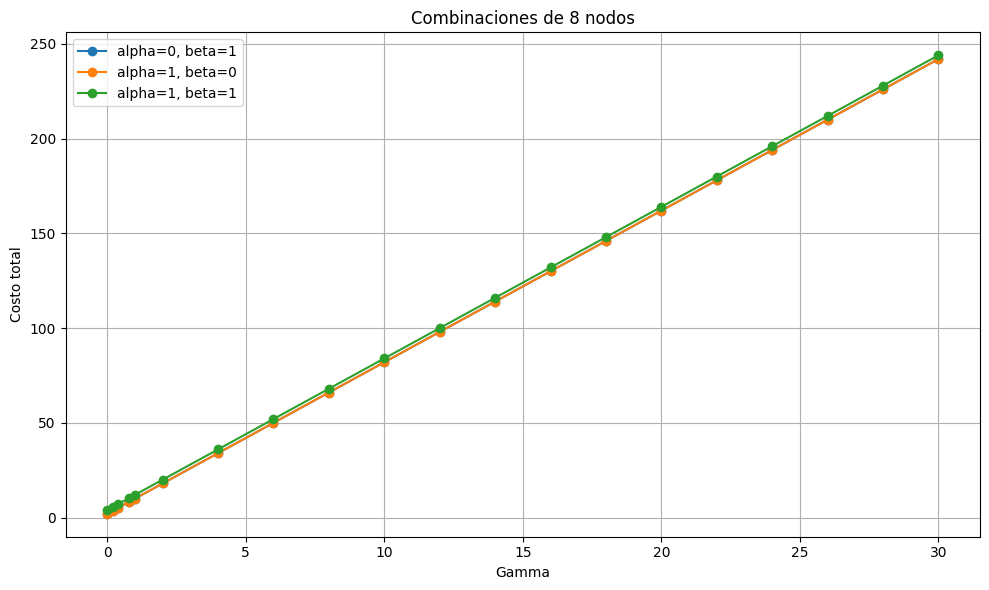

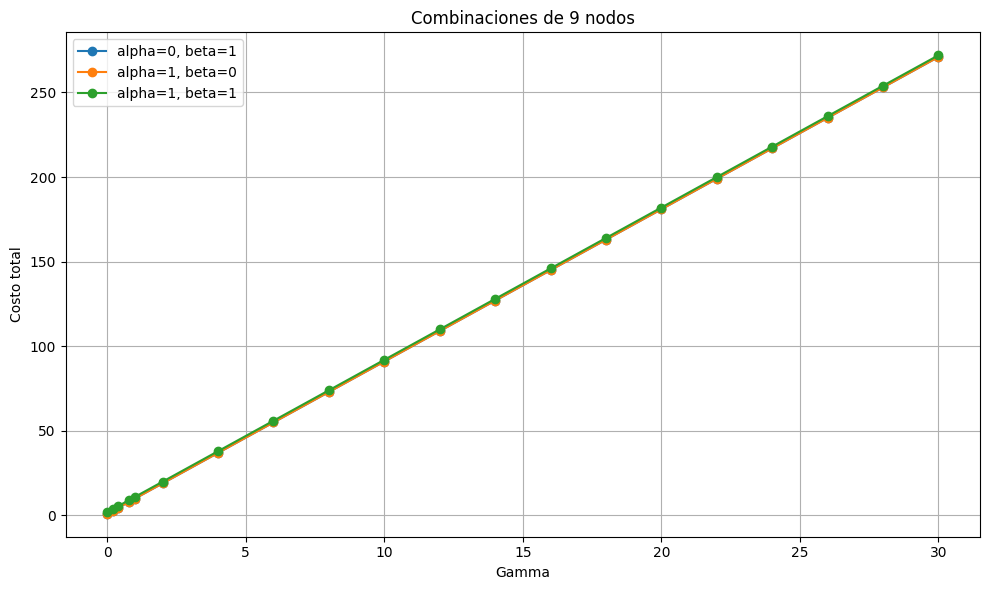

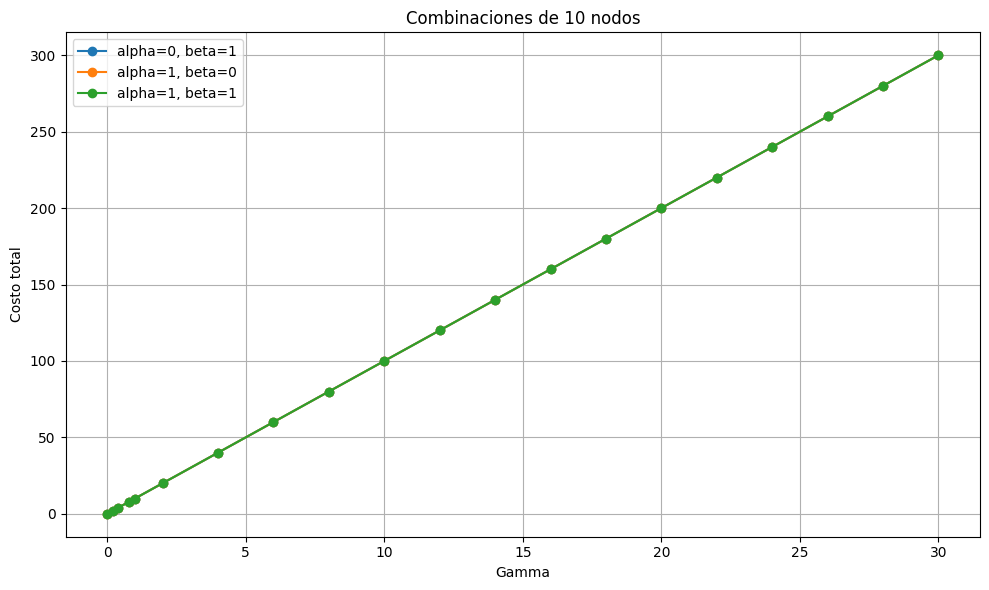

In [30]:
import matplotlib.pyplot as plt
#CODIGO CON APOYO DE CHATGPT

def generar_graficos(alpha, beta, gammas, combinaciones, G):
    #iterar por cada combinación de nodos
    for num_comb, combinacion in enumerate(combinaciones, start=1):
        plt.figure(figsize=(10, 6))  # Crear una nueva figura para cada combinación
        
        #instancia 1, 2, 3
        for alpha_beta in [(0, 1),(1, 0), (1, 1)]:
            alpha, beta = alpha_beta
            costos = []  
            
            #iterar sobre cada valor de gamma
            for gamma in gammas:
                #crea un diccionario con los costos para cada par en la combinación actual
                dict_costos_totales = {
                    par: varios_nodos_costos(G, alpha, beta, gamma, par)[0]
                    for par in combinacion
                }
                #menor costo entre los pares
                costo_min = min(dict_costos_totales.values())
                costos.append(costo_min)  # Agregar el menor costo a la lista
            
            #graficar los resultados
            plt.plot(
                gammas,  # Valores en el eje X (gamma)
                costos,  # Valores en el eje Y (costos)
                marker='o',  # Marcador de puntos
                label=f"alpha={alpha}, beta={beta}"  # Etiqueta para la leyenda
            )
        
        # Configurar título y etiquetas del gráfico
        plt.title(f'Combinaciones de {num_comb} nodos')
        plt.xlabel('Gamma')
        plt.ylabel('Costo total')
        plt.legend()  # Mostrar la leyenda
        plt.grid(True)  # Activar la cuadrícula
        plt.tight_layout()  # Ajustar el espaciado del gráfico
        plt.show()  # Mostrar el gráfico

# Llama a la función con tus valores reales.
# Nota: Asegúrate de que alphas[0], betas[0], gammas, combinaciones, y G estén definidos correctamente.
generar_graficos(alphas[0], betas[0], gammas, combinaciones, G)

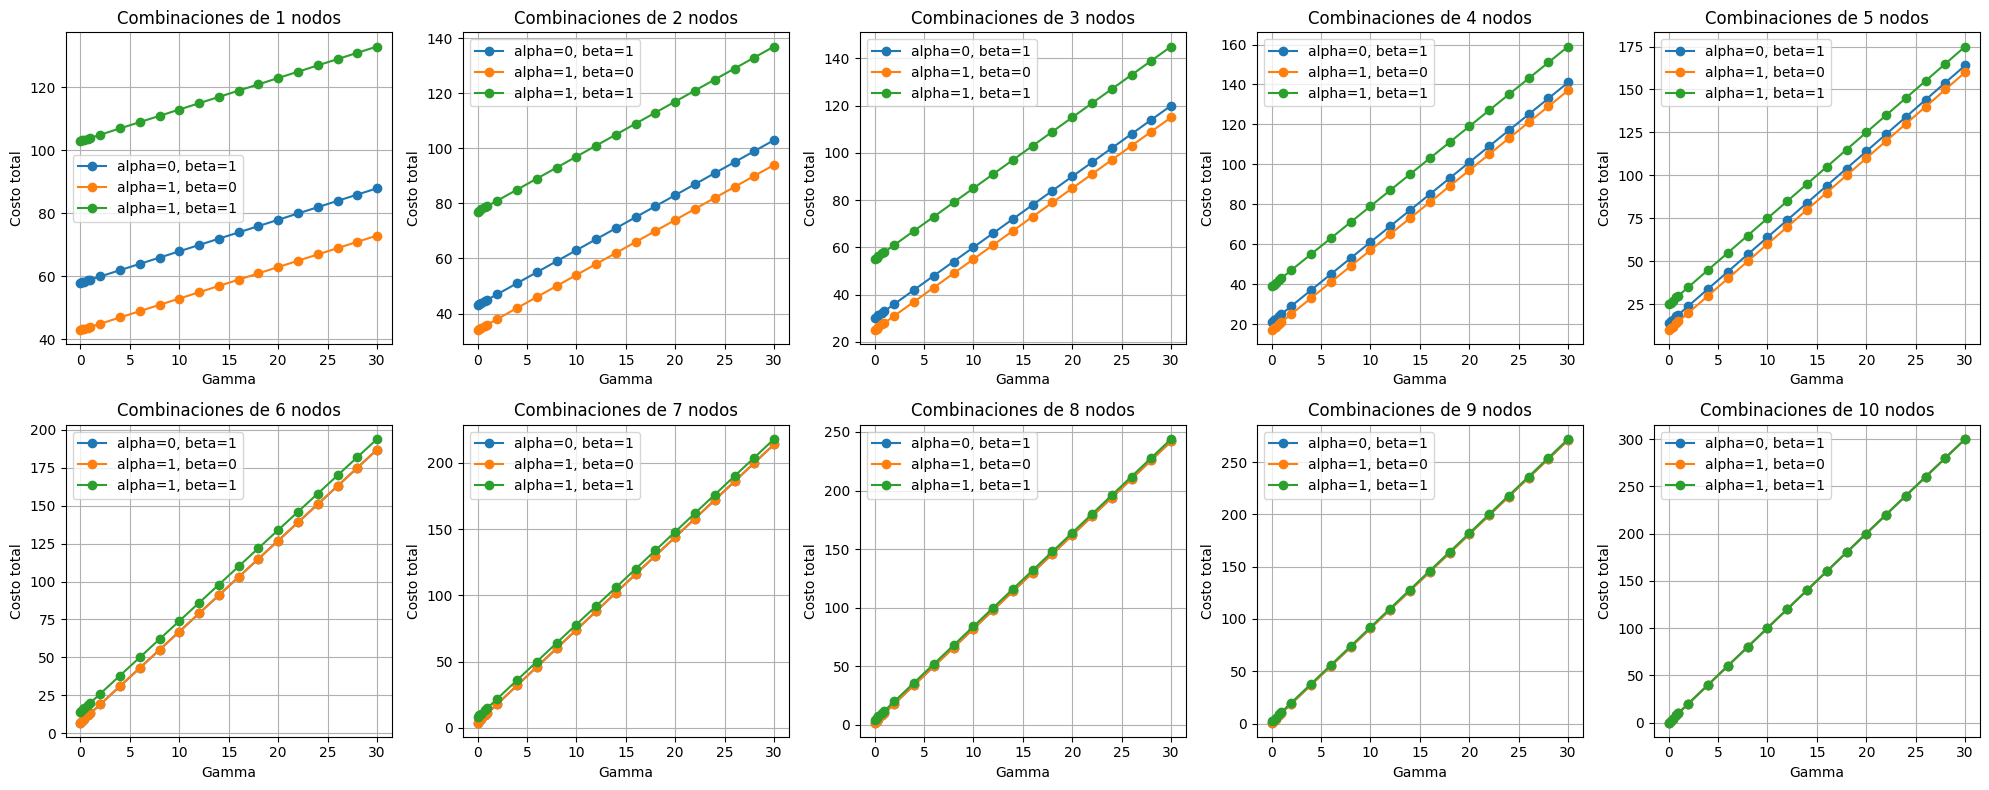

In [31]:
import matplotlib.pyplot as plt
import math
#CODIGO CON APOYO DE CHATGPT

def generar_graficos(alpha, beta, gammas, combinaciones, G):
    # Crear la figura con subplots
    num_graficos = len(combinaciones)
    filas = math.ceil(num_graficos / 5)  # Calcular cuántas filas se necesitan
    columnas = 5  # Máximo 5 gráficos por fila
    fig, axes = plt.subplots(filas, columnas, figsize=(20, 4 * filas))  # Ajustar el tamaño

    # Asegurar que axes sea iterable, incluso si hay una sola fila
    axes = axes.flatten() if filas > 1 else [axes]
    
    for num_comb, (combinacion, ax) in enumerate(zip(combinaciones, axes), start=1):
        for alpha_beta in [(0, 1), (1, 0), (1, 1)]:
            alpha, beta = alpha_beta
            costos = []
            
            for gamma in gammas:
                dict_costos_totales = {
                    par: varios_nodos_costos(G, alpha, beta, gamma, par)[0]
                    for par in combinacion
                }
                costo_min = min(dict_costos_totales.values())
                costos.append(costo_min)
            
            ax.plot(
                gammas, 
                costos, 
                marker='o', 
                label=f"alpha={alpha}, beta={beta}"
            )
        
        # Configurar título y etiquetas del subplot actual
        ax.set_title(f'Combinaciones de {num_comb} nodos')
        ax.set_xlabel('Gamma')
        ax.set_ylabel('Costo total')
        ax.legend()
        ax.grid(True)
    
    # Ocultar ejes vacíos si hay menos combinaciones que subplots
    for i in range(num_comb, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()  # Ajustar el espaciado del gráfico
    plt.show()  # Mostrar todos los gráficos en una sola figura

# Llama a la función con tus valores reales.
generar_graficos(alphas[0], betas[0], gammas, combinaciones, G)
